#### CloudSat collocations - Preprocessing

This notebook combines TIWP estimates from the various cloud datasets that were collocated with CloudSat estimates into single files.

In [1]:
from pathlib import Path
from typing import Dict

import cmocean
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
plt.style.use("../../ccic.mplstyle")

In [2]:
LAT_LIMITS = (-70, 69)

> **NOTE**:  The CloudSat-CCIC collocations only contain profiles within (-70, 69). Therefore, only those profiles are extracted here.

### Utility functions

The functions below extract dates from collocation files to simplify checking the temporal coverage of the extracted collocations.

In [3]:
from datetime import datetime
from typing import Union
from pansat.time import to_datetime64
from typing import List


def get_date(fname: Union[Path, str]) -> np.datetime64:
    """
    Extract date from collocation file.

    Args:
        fname: Filename of path pointing to a collocation file.

    Return:
         A np.datetime64 object representing the time of the collocation.
    """
    if isinstance(fname, str):
        fname = Path(fname)

    date = datetime.strptime(fname.name.split('_')[-2], "%Y%m%d%H%M%S")
    return to_datetime64(date)

In [4]:
def plot_collocation_availability(files: List[Path]) -> None:
    """
    Plot number of available collocations by month.

    Args:
         files: A list containing the collocation files.
    """
    dates = np.array(list(map(get_date, files)))
    start_time = dates.min()
    end_time = dates.max()
    print(start_time, end_time)
    bins = np.arange(start_time, end_time + np.timedelta64(1, "h"), np.timedelta64(1, "D"))
    print(bins)
    y = np.histogram(dates, bins)[0]
    x = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])
    plt.plot(x, y)

## ISCCP

The following steps are used here to extract TIWP estimates from ISCCP files:

1. Load cloud type amount (``cldamt_types``) and mask values outside the valid range $[-500, 500]$ as defined in the variable description
2. Load cloud water path by type (``wp_type``) and mask values outside the valid range $[-500, 500]$ as defined in the variable description
3. Load ``scene`` variable and mask night-time pixels, which have mask values $\geq 100$

The third step is necessary because ``wp_type`` is available only during day and for cloudy pixels thus making it impossible to distinguish non-cloudy and night-time pixels. ``cldamt_types``, however, is calculated for both day-time and night-time pixels thus not providing any way to discriminate day-time and night-time pixels.

In [5]:
isccp_data = xr.load_dataset("/scratch/ccic_record/data/isccp/ISCCP-Basic.HGG.v01r00.GLOBAL.2006.06.02.1500.GPC.10KM.CS00.EA1.00.nc")
cloud_types = isccp_data.cloud_type_label
frozen_cloud_mask = np.array(
    ["_ice" in cloud_type.decode() for cloud_type in cloud_types.data]
)

In [60]:
isccp_data

<xarray.Dataset> Size: 46MB
Dimensions:             (satpos: 12, time: 1, lat: 180, lon: 360, edge: 2,
                         levpc: 7, levtau: 6, cloud_irtype: 3, cloud_type: 18)
Coordinates:
  * lon                 (lon) float32 1kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * lat                 (lat) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * levpc               (levpc) float32 28B 95.0 245.0 375.0 ... 740.0 912.5
  * levtau              (levtau) float32 24B 0.5 2.3 6.0 14.5 34.74 109.8
  * time                (time) datetime64[ns] 8B 2006-06-02T15:00:00
Dimensions without coordinates: satpos, edge, cloud_irtype, cloud_type
Data variables: (12/43)
    satcodes            (satpos) int16 24B 57 46 23 34 44 16 65 0 0 0 0 0
    satids              (satpos) |S4 48B b'MTS1' b'MET7' ... b'    ' b'    '
    satnames            (satpos) |S20 240B b'MTS-1               ' ... b'    ...
    eqheight            (time, lat, lon) int16 130kB 2870 2870 2870 ... 0 0 0
    lon_bounds          (lon, edge) float32 3kB 0.0 1.0 1.0 ... 359.0 360.0
    lat_bounds          (lat, edge) float32 1kB -90.0 -89.0 -89.0 ... 89.0 90.0
    ...                  ...
    tc_pcdist           (time, levpc, lat, lon) float32 2MB -3.027e+03 ... -3...
    pc_type             (time, cloud_type, lat, lon) float32 5MB -3.227e+04 ....
    tc_type             (time, cloud_type, lat, lon) float32 5MB -3.027e+03 ....
    tau_type            (time, cloud_type, lat, lon) float32 5MB -102.7 ... -...
    wp_type             (time, cloud_type, lat, lon) float32 5MB -776.7 ... -...
    time_bounds         (time, edge) datetime64[ns] 16B 2006-06-02T14:00:00 2...
Attributes: (12/67)
    Conventions:                              CF-1.6, ACDD-1.3
    summary:                                  The HGG product represents glob...
    keywords:                                 EARTH SCIENCE > ATMOSPHERE > AT...
    keywords_vocabulary:                      NASA Global Change Master Direc...
    platform_vocabulary:                      NASA Global Change Master Direc...
    instrument_vocabulary:                    NASA Global Change Master Direc...
    ...                                       ...
    geospatial_lon_min:                       0.0
    geospatial_lon_max:                       360.0
    geospatial_lon_resolution:                1.0
    geospatial_vertical_min:                  10.0
    geospatial_vertical_max:                  1025.0
    history:                                  Sun May  7 02:47:56 2017: ncatt...

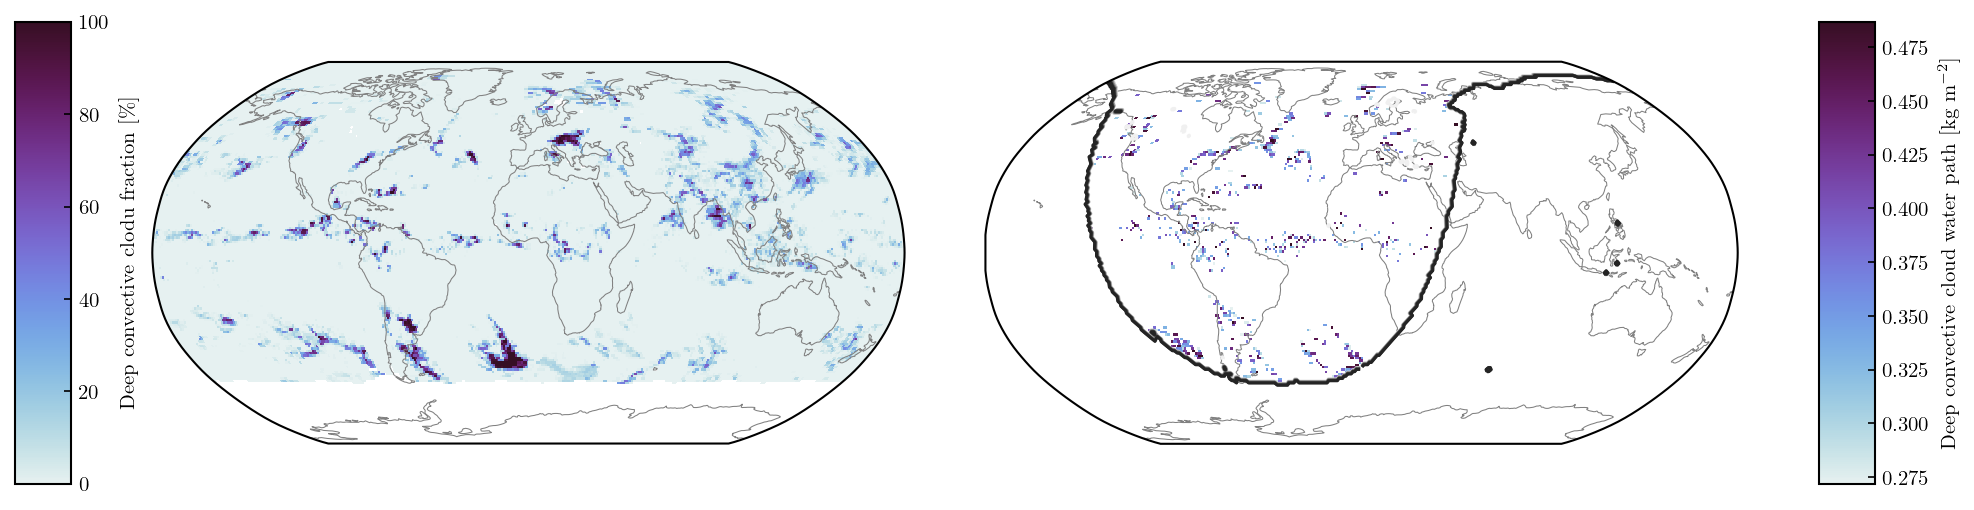

In [6]:
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec

crs = ccrs.Robinson()

fig = plt.figure(figsize=(16, 4))
gs = GridSpec(1, 4, width_ratios=[0.075, 1.0, 1.0, 0.075])

# CLDAMT
ax = fig.add_subplot(gs[0, 1], projection=crs)
cldamt_dc = isccp_data.cldamt_types[0, -1].data.copy()
invalid = (cldamt_dc < -500) + (cldamt_dc > 500)
cldamt_dc[invalid] = np.nan
lats = isccp_data.lat.data
lons = isccp_data.lon.data
m = ax.pcolormesh(lons, lats, cldamt_dc, transform=ccrs.PlateCarree())
ax.coastlines(color="grey")

cax = fig.add_subplot(gs[0, 0])
plt.colorbar(m, cax=cax, label="Deep convective cloud fraction [$\si{\percent}$]")

# WP
ax = fig.add_subplot(gs[0, 2], projection=crs)
wp_dc = isccp_data.wp_type[0, -1].data.copy()
invalid = (wp_dc < -500) + (wp_dc > 500)
wp_dc[invalid] = np.nan
lats = isccp_data.lat.data
lons = isccp_data.lon.data
scene = isccp_data.scene.data[0]
m = ax.pcolormesh(lons, lats, wp_dc / 1e3, transform=ccrs.PlateCarree())
ax.contour(lons, lats, scene, cmap="Greys", transform=ccrs.PlateCarree())
ax.coastlines(color="grey")

cax = fig.add_subplot(gs[0, 3])
plt.colorbar(m, cax=cax, label="Deep convective cloud water path [kg m$^{-2}$]")

In [49]:
frozen_cloud_mask

array([False, False, False,  True,  True,  True, False, False, False,
        True,  True,  True, False, False, False,  True,  True,  True])

In [7]:
def get_tiwp_isccp(dataset: xr.Dataset) -> xr.DataArray:
    """
    Extract ISCCP TIWP from collocation file.

    Args:
        dataset: A xarray.Dataset containing ISCCP-CloudSat collocations.

    Return:
        A DataArray containing the extracted TIWP
    """
    lat_mask = (LAT_LIMITS[0] < dataset.latitude) * (dataset.latitude < LAT_LIMITS[1])
    dataset = dataset[{"rays": lat_mask}]
    day_flag = dataset.scene.data < 100

    tiwp = np.zeros_like
    wp_type = dataset.wp_type.data.copy()
    wp_type[wp_type < 0] = np.nan
    wp_type[wp_type > 500] = np.nan
    wp_type[np.isnan(wp_type) * day_flag[..., None]] = 0.0

    cldamt_types = dataset.cldamt_types.data.copy()
    cldamt_types[cldamt_types <= -500] = np.nan
    cldamt_types[cldamt_types > 500] = np.nan
    
    tiwp = (wp_type * 1e-3 * cldamt_types / 100.0)[..., frozen_cloud_mask].sum(-1)
    return xr.DataArray(
        tiwp,
        dims=("rays",),
        coords = {
            "time": (("rays",), dataset.time.data),
            "latitude": (("rays",), dataset.latitude.data),
            "longitude": (("rays"), dataset.longitude.data),
        }
    )

### Temporal coverage

In [8]:
files = sorted(list(Path("/scratch/ccic_record/collocations/isccp").glob("*.nc")))

2006-06-02T13:42:29.000000000 2017-06-04T03:28:46.000000000
['2006-06-02T13:42:29.000000000' '2006-06-03T13:42:29.000000000'
 '2006-06-04T13:42:29.000000000' ... '2017-06-01T13:42:29.000000000'
 '2017-06-02T13:42:29.000000000' '2017-06-03T13:42:29.000000000']


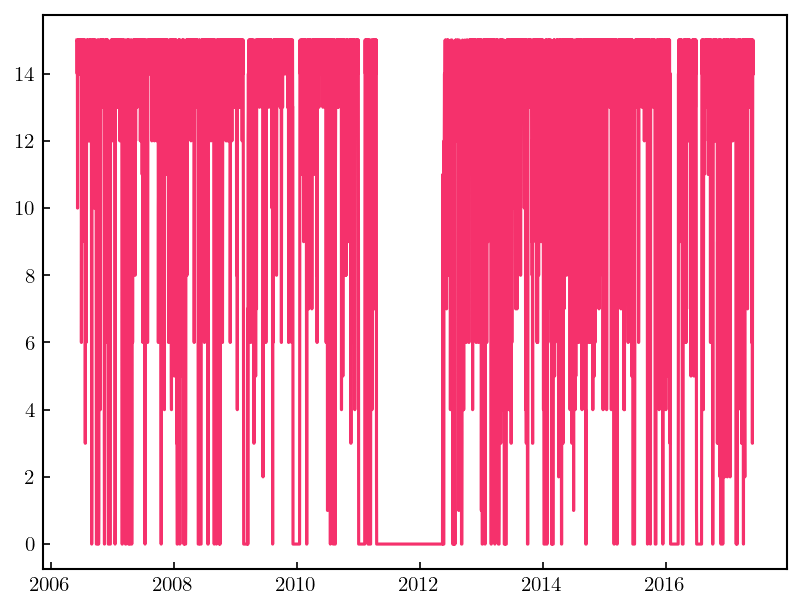

In [9]:
plot_collocation_availability(files)

## PATMOS-x

The problem is similar for PATMOS-x data in that WP values are only available for cloudy day-time pixels requiring them to be combined with a day-time flag to distinguish pixels without IWP from those where no retrieval was performed. For PATMOS-x the following steps are performed:

1. Determine pixels with valid retrieval results using pixels where the DCOMP-determined optical depth is finite (``np.isfinite(patmosx_data.cld_opd_dcomp)``)
2. Determine IWP for cloudy pixels by extracting the water path (``cld_cwp_dcomp.``) for ice clouds ``cloud_phase == 4``.

In [13]:
patmosx_data = xr.load_dataset("/scratch/ccic_record/data/PATMOS-x/raw_custom/patmosx_v06r00_NOAA-19_des_d20210515_c20231219_v2.zarr")

/scratch/spfrnd/micromamba/envs/ccic_record/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/scratch/spfrnd/micromamba/envs/ccic_record/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/scratch/spfrnd/micromamba/envs/ccic_record/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


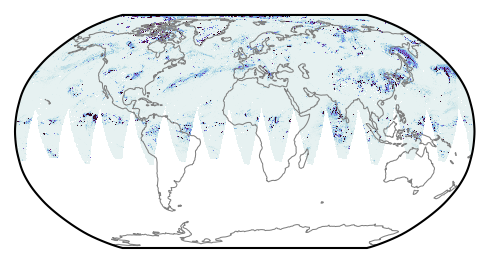

In [15]:
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec

crs = ccrs.Robinson()

fig = plt.figure(figsize=(10, 5))
gs = GridSpec(1, 2, width_ratios=[0.1, 1.0, 1.0, 0.1])

# Cloud water path
ax = fig.add_subplot(gs[0, 2], projection=crs)
ax.pcolormesh(lons, lats, patmosx_data.cld_iwp_dcomp.data[0, ::4, ::4], transform=ccrs.PlateCarree())
#ax.contour(lons, lats, np.isfinite(patmosx_data.cld_opd_dcomp.data[0, ::4, ::4]), transform=ccrs.PlateCarree(), cmap="Greys")
ax.coastlines(color="grey")

In [104]:
def get_tiwp_patmosx(dataset: xr.Dataset) -> xr.DataArray:
    """
    Extract PATMOS-x TIWP from collocation file.

    Args:
        dataset: A xarray.Dataset containing PATMOS-x/CloudSat collocations.

    Return:
        A DataArray containing the extracted TIWP
    """
    lat_mask = (dataset.latitude > LAT_LIMITS[0]) * (dataset.latitude < LAT_LIMITS[1])
    dataset = dataset[{"rays": lat_mask}]

    tiwp = dataset.cld_iwp_dcomp.data
    return xr.DataArray(
        tiwp,
        dims=("rays",),
        coords = {
            "latitude": (("rays",), dataset.latitude.data),
            "longitude": (("rays"), dataset.longitude.data),
        }
    )

### Temporal coverage

In [90]:
files = sorted(list(Path("/scratch/ccic_record/collocations/patmosx").glob("*.nc")))

2006-06-12T20:55:32.000000000 2017-03-25T05:01:37.000000000
['2006-06-12T20:55:32.000000000' '2006-06-13T20:55:32.000000000'
 '2006-06-14T20:55:32.000000000' ... '2017-03-22T20:55:32.000000000'
 '2017-03-23T20:55:32.000000000' '2017-03-24T20:55:32.000000000']


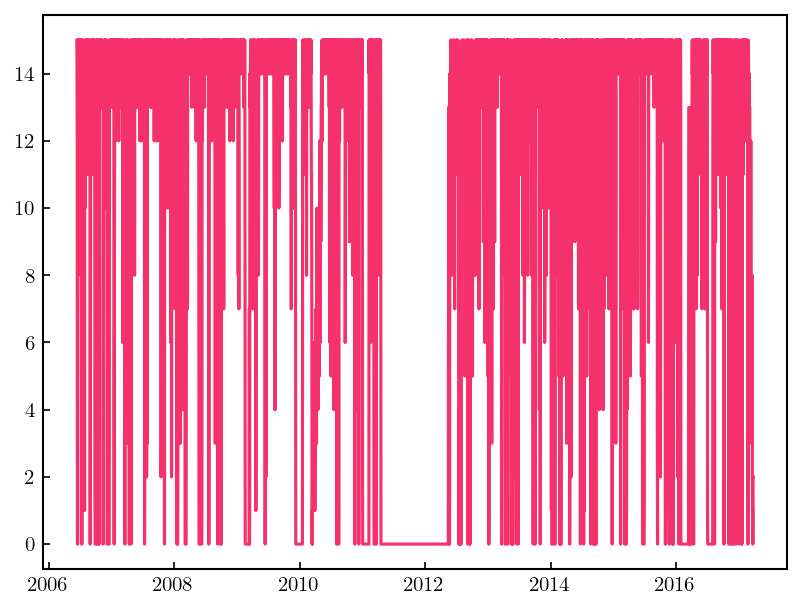

In [91]:
plot_collocation_availability(files)

In [ ]:
files = sorted(list(Path("/scratch/ccic_record/collocations/patmosx_new/").glob("*.nc")))
for fle in files:
    with xr.open_dataset(fle) as data:
        print(fle, np.isfinite(data.cld_iwp_dcomp.data).mean() > 0.1)

/scratch/ccic_record/collocations/patmosx_new/patmosx_20081231225751_14251.nc False
/scratch/ccic_record/collocations/patmosx_new/patmosx_20090101003644_14252.nc True
/scratch/ccic_record/collocations/patmosx_new/patmosx_20090101021537_14253.nc True
/scratch/ccic_record/collocations/patmosx_new/patmosx_20090101035430_14254.nc True
/scratch/ccic_record/collocations/patmosx_new/patmosx_20090101053323_14255.nc True
/scratch/ccic_record/collocations/patmosx_new/patmosx_20090101071216_14256.nc True
/scratch/ccic_record/collocations/patmosx_new/patmosx_20090101085109_14257.nc True
/scratch/ccic_record/collocations/patmosx_new/patmosx_20090101103003_14258.nc True
/scratch/ccic_record/collocations/patmosx_new/patmosx_20090101120856_14259.nc True
/scratch/ccic_record/collocations/patmosx_new/patmosx_20090101134749_14260.nc True
/scratch/ccic_record/collocations/patmosx_new/patmosx_20090101152642_14261.nc True
/scratch/ccic_record/collocations/patmosx_new/patmosx_20090101170535_14262.nc True
/sc

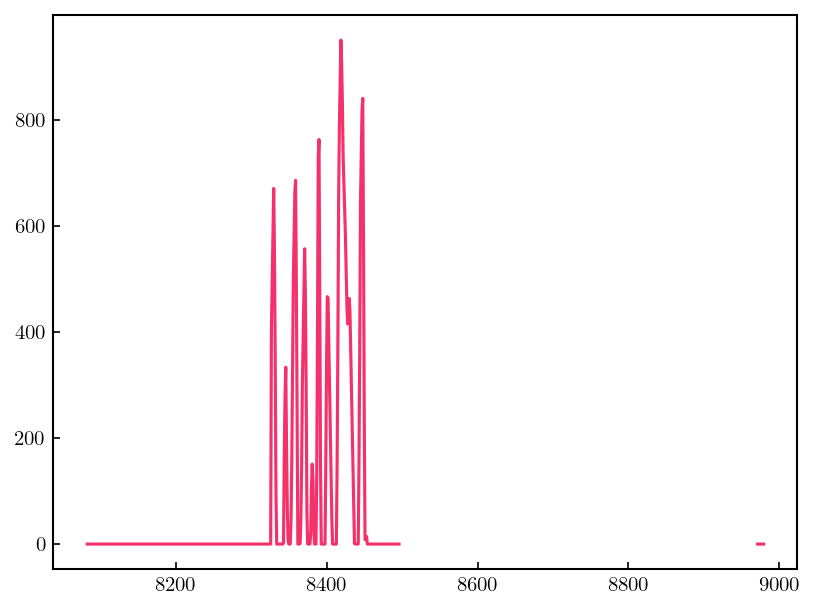

In [160]:
plt.plot(data.cld_iwp_dcomp)

In [167]:
with xr.open_dataset("/scratch/ccic_record/data/PATMOS-x/raw_custom/patmosx_v06r00_NOAA-19_des_d20210602_c20231220_v2.zarr") as data:
    slt = data["scan_line_time"]
    


/scratch/spfrnd/micromamba/envs/ccic_record/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/scratch/spfrnd/micromamba/envs/ccic_record/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/scratch/spfrnd/micromamba/envs/ccic_record/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [169]:
slt.latitude

<xarray.DataArray 'latitude' (latitude: 1800)> Size: 14kB
array([-89.950568, -89.848941, -89.750061, ...,  89.750061,  89.848941,
        89.950568])
Coordinates:
  * latitude  (latitude) float64 14kB -89.95 -89.85 -89.75 ... 89.75 89.85 89.95
Attributes:
    _CoordinateAxisType:  Lat
    actual_missing:       -999.0
    actual_range:         [-90.0, 90.0]
    axis:                 Y
    long_name:            latitude
    standard_name:        latitude
    units:                degrees_north
    valid_range:          [-32767, 32767]

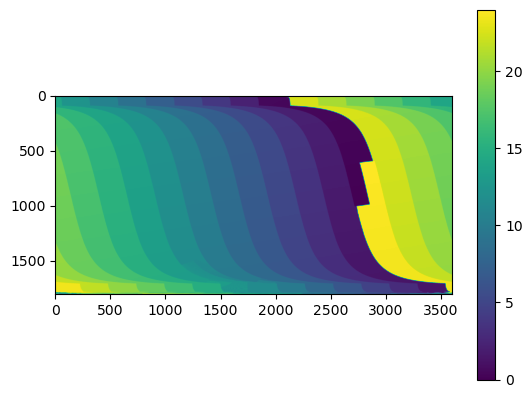

In [41]:
plt.imshow(slt[0] / 3600)
plt.colorbar()

In [63]:
data

<xarray.Dataset> Size: 3MB
Dimensions:            (rays: 37082)
Coordinates:
    time               datetime64[ns] 8B 2009-01-01
    latitude           (rays) float64 297kB -0.0004046 -0.01007 ... 0.008612
    longitude          (rays) float64 297kB 105.8 105.8 105.8 ... 81.07 81.06
  * rays               (rays) int64 297kB 0 1 2 3 4 ... 37078 37079 37080 37081
    surface_elevation  (rays) int64 297kB -9999 -9999 -9999 ... -9999 -9999
Data variables:
    scan_line_time     (rays) datetime64[ns] 297kB NaT NaT NaT ... NaT NaT NaT
    cloud_probability  (rays) float64 297kB nan nan nan nan ... nan nan nan nan
    cloud_fraction     (rays) float64 297kB nan nan nan nan ... nan nan nan nan
    cld_iwp_dcomp      (rays) float64 297kB nan nan nan nan ... nan nan nan nan
    cs_time            (rays) datetime64[ns] 297kB 2009-01-01T18:44:28 ... 20...
Attributes: (12/106)
    ACHA_MODE_FINAL:                      110_133
    ACHA_MODE_USER:                       110_133
    ACHA_SUCCESS_FRACTION:                nan
    A_20:                                 -1.7222650051116943
    A_31:                                 -0.5469623804092407
    A_32:                                 -0.3993837535381317
    ...                                   ...
    standard_name_vocabulary:             CF Standard Name Table (v72, 10 Mar...
    summary:                               Included in this file are PATMOS-x...
    time_coverage_end:                    2009-01-02T00:13:00Z
    time_coverage_resolution:             P1D
    time_coverage_start:                  2009-01-01T00:00:00Z
    title:                                PATMOS-x AVHRR reflectance, brightn...

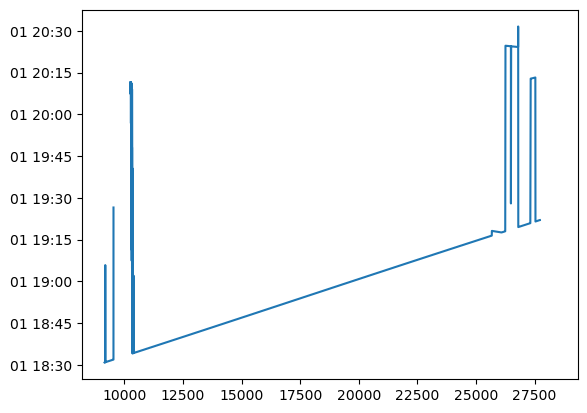

In [60]:
plt.plot(data.scan_line_time)

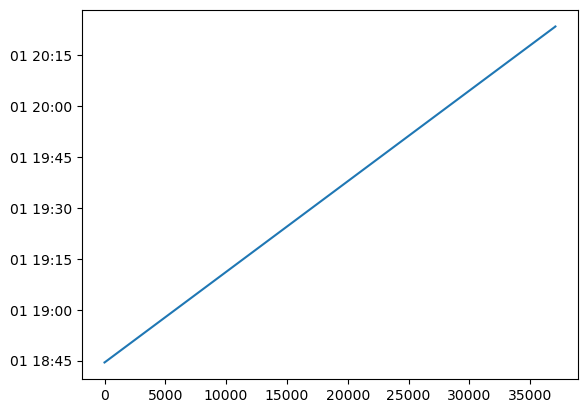

In [61]:
plt.plot(data.cs_time)

In [58]:
data.cs_time

<xarray.DataArray 'cs_time' (rays: 37082)> Size: 297kB
array(['2009-01-01T18:44:28.000000000', '2009-01-01T18:44:28.000000000',
       '2009-01-01T18:44:28.000000000', ...,
       '2009-01-01T20:23:21.000000000', '2009-01-01T20:23:21.000000000',
       '2009-01-01T20:23:21.000000000'], dtype='datetime64[ns]')
Coordinates:
    time               datetime64[ns] 8B 2009-01-01
    latitude           (rays) float64 297kB -0.0004046 -0.01007 ... 0.008612
    longitude          (rays) float64 297kB 105.8 105.8 105.8 ... 81.07 81.06
  * rays               (rays) int64 297kB 0 1 2 3 4 ... 37078 37079 37080 37081
    surface_elevation  (rays) int64 297kB -9999 -9999 -9999 ... -9999 -9999

In [74]:
data.scan_line_time.data.dtype

dtype('<M8[ns]')

In [75]:
data.cs_time.data.dtype

dtype('<M8[ns]')

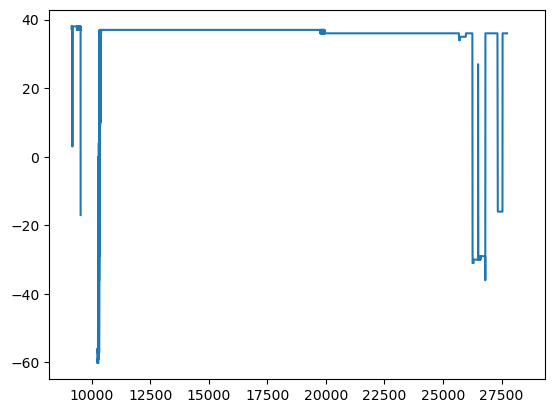

In [76]:
d_t = data.cs_time.data - data.scan_line_time.data
mask = np.isfinite(d_t)
diff = d_t.astype("timedelta64[m]").astype("float32")
diff[~mask] = np.nan

plt.plot(diff)


In [16]:
xr.load_dataset(files[0])

<xarray.Dataset> Size: 2MB
Dimensions:            (rays: 37083)
Coordinates:
    time               datetime64[ns] 8B 2006-06-12
    latitude           (rays) float64 297kB -0.004195 -0.01386 ... 0.005102
    longitude          (rays) float64 297kB 71.75 71.74 71.74 ... 47.03 47.03
  * rays               (rays) int64 297kB 0 1 2 3 4 ... 37079 37080 37081 37082
    surface_elevation  (rays) int64 297kB -9999 -9999 -9999 ... -9999 -9999
Data variables:
    scan_line_time     (rays) datetime64[ns] 297kB NaT NaT NaT ... NaT NaT NaT
    cloud_probability  (rays) float64 297kB nan nan nan nan ... nan nan nan nan
    cloud_fraction     (rays) float64 297kB nan nan nan nan ... nan nan nan nan
    cld_iwp_dcomp      (rays) float64 297kB nan nan nan nan ... nan nan nan nan
Attributes: (12/101)
    ACHA_MODE_FINAL:                      110_133
    ACHA_MODE_USER:                       110_133
    ACHA_SUCCESS_FRACTION:                nan
    A_20:                                 -1.624480962753296
    A_31:                                 -0.3382430076599121
    A_32:                                 -0.30485600233078003
    ...                                   ...
    standard_name_vocabulary:             CF Standard Name Table (v72, 10 Mar...
    summary:                               Included in this file are PATMOS-x...
    time_coverage_end:                    2006-06-13T00:39:00Z
    time_coverage_resolution:             P1D
    time_coverage_start:                  2006-06-11T23:10:00Z
    title:                                PATMOS-x AVHRR reflectance, brightn...

## MODIS

Just as ISCCP and PATMOS-x, the standard MODIS water path retrievals are limited to cloudy day-time pixels. For MODIS, however, the ``cloud_phase`` variable can be used to distinguish day-time from night-time results.

A special issue with the MODIS collocations, which are derived from the MOD06-1km-AUX product is that the latitude coordinate does not match those of CloudSat identically and thus the extraction of rays within the latitude bounds leads to inconsistent number of profiles with respect to the CloudSat/CCIC collocations. The ``get_tiwp_modis`` therefore use ``time`` as dimension to allow for interpolating of the data to the CloudSat/CCIC collocations.

In [103]:
def get_tiwp_modis(dataset: xr.Dataset) -> xr.DataArray:
    """
    Determine MODIS TIWP from collocations file.

    Args:
        dataset: A xarray.Dataset containing MODIS collocations.

    Return:
        A DataArray containing the extracted TIWP
    """
    dataset = dataset[{"modis_pixels": 7}]
    valid_rays = (LAT_LIMITS[0] < dataset.latitude.data) * (dataset.latitude.data < LAT_LIMITS[1])
    dataset = dataset[{"rays": valid_rays}]
    
    valid = np.concatenate([[True], np.diff(dataset.time.data) > np.timedelta64(0, "ns")], 0)
    dataset = dataset[{"rays": valid}]
                           
    cloud_phase = dataset.cloud_phase
    cloud_water_path = dataset.cloud_water_path
    # Mask values with undertermined cloud phase.
    ice_mask = cloud_phase.data == 3
    tiwp = np.zeros(dataset.rays.size, dtype="float32")
    tiwp[ice_mask] = dataset.cloud_water_path.data[ice_mask] / 1e3
    tiwp[tiwp < 0] = np.nan
    tiwp[cloud_phase.data <= 0] = np.nan
    tiwp[cloud_phase.data == 4] = np.nan
    
    return xr.DataArray(
        tiwp,
        dims=("time",),
        coords = {
            "time": (("time",), dataset.time.data),
            "latitude": (("time",), dataset.latitude.data),
            "longitude": (("time"), dataset.longitude.data),
        }
    )

2006-06-02T13:42:29.000000000 2017-12-05T14:11:07.000000000
['2006-06-02T13:42:29.000000000' '2006-06-03T13:42:29.000000000'
 '2006-06-04T13:42:29.000000000' ... '2017-12-03T13:42:29.000000000'
 '2017-12-04T13:42:29.000000000' '2017-12-05T13:42:29.000000000']


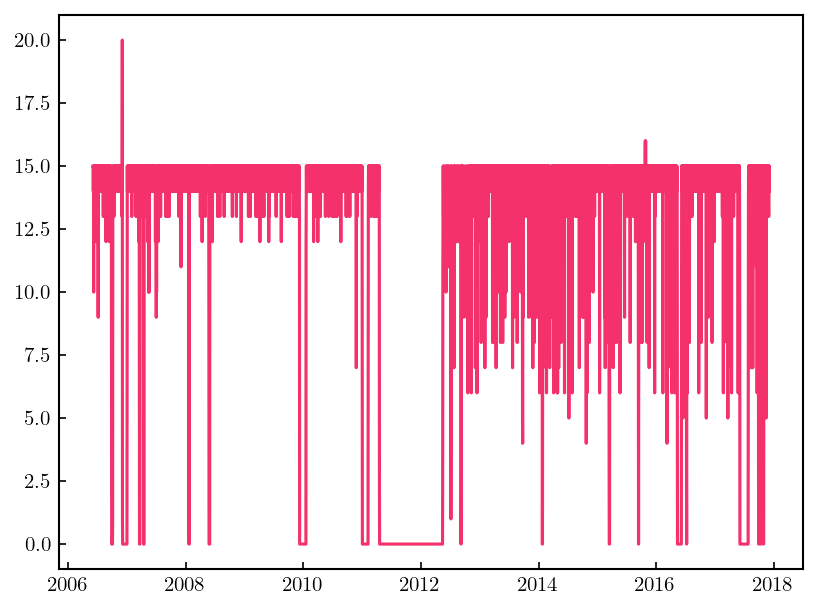

In [22]:
files = sorted(list(Path("/scratch/ccic_record/collocations/modis").glob("*.nc")))
plot_collocation_availability(files)

## Combine data

In [16]:
def find_granules(path: Path) -> Dict[int, Path]:
    """
    Compile dictionary mapping granules to filenames.

    Args:
        path: A path object pointing to a directory containing CloudSat collocations.

    Return:
        A dictionary mapping granule number to corresponding collocations files.
    """
    path = Path(path)
    files = sorted(list(path.glob("*.nc")))
    granules = {}
    for path in files:
        granule = int(path.name.split("_")[-1][:-3])
        granules[granule] = path
    return granules


In [17]:
modis_granules = find_granules("/scratch/ccic_record/data/collocations/modis/")
isccp_granules = find_granules("/scratch/ccic_record/data/collocations/isccp")
patmosx_granules = find_granules("/scratch/ccic_record/collocations/patmosx_new/")
cloudsat_granules = find_granules("/scratch/ccic_record/data/cloudsat/cloudsat_collocations")
common = set(modis_granules).intersection(isccp_granules).intersection(cloudsat_granules).intersection(patmosx_granules)


In [95]:
%rm -rf /scratch/ccic_record/data/collocations/combined

In [96]:
%mkdir /scratch/ccic_record/data/collocations/combined

In [106]:
import logging
from tqdm import tqdm
from pansat.time import to_datetime

LOGGER = logging.getLogger("log")

output_path = Path("/scratch/ccic_record/data/collocations/combined")
output_path.mkdir(exist_ok=True)
for granule in tqdm(sorted(list(common))):
    try:
        cs_data = xr.load_dataset(cloudsat_granules[granule])
        data = cs_data.rename(
            iwp_ccic="tiwp_ccic",
            iwp_2cice="tiwp_2cice",
            iwp_dardar="tiwp_dardar"
        )
        data["tiwp_modis"] = get_tiwp_modis(xr.load_dataset(modis_granules[granule])).interp(time=cs_data.time)
        data["tiwp_isccp"] = get_tiwp_isccp(xr.load_dataset(isccp_granules[granule]))
        data["tiwp_patmosx"] = get_tiwp_patmosx(xr.load_dataset(patmosx_granules[granule]))
        start_time = to_datetime(data.time[0].data)
        time_str = start_time.strftime("%Y%m%d%H%M%S")
        filename = f"cloudsat_collocations_{time_str}_{granule}.nc"
        data.to_netcdf(output_path / filename)
    except Exception:
        print(cs_data)
        LOGGER.exception(f"Encountered error processing granule {granule}.")

  0%|                                                                           | 0/655 [00:00<?, ?it/s]Encountered error processing granule 14251.
Traceback (most recent call last):
  File "/tmp/ipykernel_2803149/2635397258.py", line 17, in <module>
    data["tiwp_modis"] = get_tiwp_modis(xr.load_dataset(modis_granules[granule])).interp(time=cs_data.time)
  File "/scratch/spfrnd/micromamba/envs/ccic_record/lib/python3.10/site-packages/xarray/core/dataarray.py", line 2341, in interp
    ds = self._to_temp_dataset().interp(
  File "/scratch/spfrnd/micromamba/envs/ccic_record/lib/python3.10/site-packages/xarray/core/dataset.py", line 4050, in interp
    obj, newidx = missing._localize(obj, {k: v})
  File "/scratch/spfrnd/micromamba/envs/ccic_record/lib/python3.10/site-packages/xarray/core/missing.py", line 562, in _localize
    imin, imax = index.get_indexer([minval, maxval], method="nearest")
  File "/scratch/spfrnd/micromamba/envs/ccic_record/lib/python3.10/site-packages/pandas/core/in

<xarray.Dataset> Size: 2MB
Dimensions:            (rays: 29272)
Coordinates:
  * rays               (rays) int64 234kB 0 1 2 3 4 ... 29268 29269 29270 29271
    longitude          (rays) float32 117kB 42.43 42.43 42.43 ... 17.71 17.71
    latitude           (rays) float32 117kB -0.001402 -0.01107 ... 0.005607
    time               (rays) datetime64[ns] 234kB 2008-12-31T22:57:44.882812...
Data variables:
    iwp_ccic           (rays) float32 117kB 0.0 0.0 0.0 ... 0.01971 0.01971
    iwp_2cice          (rays) float64 234kB 0.0002494 0.0003498 ... 0.008248
    iwp_dardar         (rays) float32 117kB 0.001077 0.001205 ... 0.04369 0.0407
    cloud_mask_ccic    (rays) float32 117kB 0.008 0.008 0.008 ... 0.92 0.86 0.86
    cloud_mask_2cice   (rays) float64 234kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cloud_mask_dardar  (rays) float64 234kB 0.06475 0.05516 ... 0.5874 0.5801
Attributes:
    cloudsat_granule:    14251
    cloudsat_timestamp:  2008366225744


/home/spfrnd/src/pansat/pansat/time.py:27: UserWarning: Discarding nonzero nanoseconds in conversion.
  return pd.to_datetime(time).to_pydatetime()
  0%|▏                                                                  | 2/655 [00:00<05:12,  2.09it/s]/home/spfrnd/src/pansat/pansat/time.py:27: UserWarning: Discarding nonzero nanoseconds in conversion.
  return pd.to_datetime(time).to_pydatetime()
  0%|▎                                                                  | 3/655 [00:01<04:25,  2.46it/s]/home/spfrnd/src/pansat/pansat/time.py:27: UserWarning: Discarding nonzero nanoseconds in conversion.
  return pd.to_datetime(time).to_pydatetime()
  1%|▍                                                                  | 4/655 [00:01<03:43,  2.92it/s]/home/spfrnd/src/pansat/pansat/time.py:27: UserWarning: Discarding nonzero nanoseconds in conversion.
  return pd.to_datetime(time).to_pydatetime()
  1%|▌                                                                  | 5/655 [00:01<03:15,  3

## Aggregate results

In [107]:
from filelock import FileLock
from scipy.stats import binned_statistic_2d
from pansat.time import to_datetime

ref_product = "2cice"
products = ["dardar", "modis", "isccp", "patmosx", "ccic"]

N_LONS = 72
N_LATS = 36
LON_BINS = np.linspace(-180, 180, N_LONS + 1)
LAT_BINS = np.linspace(-90, 90, N_LATS + 1)

def create_dataset():
    dataset = {}
    dims = ("latitude", "longitude")
    for prod in products:
        dataset[f"tiwp_{prod}_sum"] = (dims, np.zeros((N_LATS, N_LONS), dtype=np.float32))
        dataset[f"tiwp_{prod}_cts"] = (dims, np.zeros((N_LATS, N_LONS), dtype=np.float32))
        dataset[f"tiwp_{prod}_ref_sum"] = (dims, np.zeros((N_LATS, N_LONS), dtype=np.float32))
        dataset[f"tiwp_{prod}_ref_cts"] = (dims, np.zeros((N_LATS, N_LONS), dtype=np.float32))
        dataset[f"tiwp_{prod}_sqr_sum"] = (dims, np.zeros((N_LATS, N_LONS), dtype=np.float32))
        dataset[f"tiwp_{prod}_sqr_cts"] = (dims, np.zeros((N_LATS, N_LONS), dtype=np.float32))
        
    dataset[f"tiwp_ref_sum"] = (dims, np.zeros((N_LATS, N_LONS), dtype=np.float32))
    dataset[f"tiwp_ref_cts"] = (dims, np.zeros((N_LATS, N_LONS), dtype=np.float32))
    dataset[f"tiwp_ref_sqr_sum"] = (dims, np.zeros((N_LATS, N_LONS), dtype=np.float32))
    dataset[f"tiwp_ref_sqr_cts"] = (dims, np.zeros((N_LATS, N_LONS), dtype=np.float32))
    return xr.Dataset(dataset)
    

def process_file(
    path: Path,
    output_path: Path
) -> None:
    
    colloc_data = xr.load_dataset(path)

    daytime_flag = np.isfinite(colloc_data.cloud_mask_2cice.data)
    time = colloc_data.time.data
    

    year = colloc_data.time.dt.year.data
    month = colloc_data.time.dt.month.data

    years = np.unique(year)
    months = np.unique(month)

    for yr in years:
        for mnth in months:

            time_mask = (yr == year) * (mnth == month)
            filename = f"cloudsat_collocations_{yr:04}_{mnth:02}.nc"
            output_file = output_path / filename

            lock = FileLock(output_path / (filename + ".lock"))
            with lock:
                if output_file.exists():
                    dataset = xr.load_dataset(output_file)
                else:
                    dataset = create_dataset()

                valid = time_mask * daytime_flag
                
                data = colloc_data[{"rays": valid}]
                lons = data.longitude.data
                lats = data.latitude.data
                
                tiwp_ref = data[f"tiwp_{ref_product}"].data
                valid_ref = np.isfinite(tiwp_ref)
                if valid_ref.sum() < 1:
                    continue
                    
                dataset[f"tiwp_ref_sum"].data += binned_statistic_2d(
                    lons[valid_ref], lats[valid_ref], tiwp_ref[valid_ref], "sum", bins=(LON_BINS, LAT_BINS)
                )[0].T
                dataset[f"tiwp_ref_cts"].data += binned_statistic_2d(
                    lons[valid_ref], lats[valid_ref], tiwp_ref[valid_ref], "count", bins=(LON_BINS, LAT_BINS)
                )[0].T
                dataset[f"tiwp_ref_sqr_sum"].data += binned_statistic_2d(
                    lons[valid_ref], lats[valid_ref], (tiwp_ref * tiwp_ref)[valid_ref], "sum", bins=(LON_BINS, LAT_BINS)
                )[0].T
                dataset[f"tiwp_ref_sqr_cts"].data += binned_statistic_2d(
                    lons[valid_ref], lats[valid_ref], (tiwp_ref * tiwp_ref)[valid_ref], "count", bins=(LON_BINS, LAT_BINS)
                )[0].T
    
                for prod in products:
                    tiwp_prod = data[f"tiwp_{prod}"].data
                    valid_prod = np.isfinite(tiwp_prod)
                    valid_both = valid_prod * valid_ref
                    if valid_both.sum() < 1:
                        continue
    
                    dataset[f"tiwp_{prod}_sum"].data += binned_statistic_2d(
                        lons[valid_both], lats[valid_both], tiwp_prod[valid_both], "sum", bins=(LON_BINS, LAT_BINS)
                    )[0].T
                    dataset[f"tiwp_{prod}_cts"].data += binned_statistic_2d(
                        lons[valid_both], lats[valid_both], tiwp_prod[valid_both], "count", bins=(LON_BINS, LAT_BINS)
                    )[0].T
                    dataset[f"tiwp_{prod}_ref_sum"].data += binned_statistic_2d(
                        lons[valid_both], lats[valid_both], (tiwp_prod * tiwp_ref)[valid_both], "sum", bins=(LON_BINS, LAT_BINS)
                    )[0].T
                    dataset[f"tiwp_{prod}_ref_cts"].data += binned_statistic_2d(
                        lons[valid_both], lats[valid_both], (tiwp_prod * tiwp_ref)[valid_both], "count", bins=(LON_BINS, LAT_BINS)
                    )[0].T
                    dataset[f"tiwp_{prod}_sqr_sum"].data += binned_statistic_2d(
                        lons[valid_both], lats[valid_both], (tiwp_prod * tiwp_prod)[valid_both], "sum", bins=(LON_BINS, LAT_BINS)
                    )[0].T
                    dataset[f"tiwp_{prod}_sqr_cts"].data += binned_statistic_2d(
                        lons[valid_both], lats[valid_both], (tiwp_prod * tiwp_prod)[valid_both], "count", bins=(LON_BINS, LAT_BINS)
                    )[0].T

                dataset.to_netcdf(output_file)


In [108]:
output_path

PosixPath('/scratch/ccic_record/data/collocations/combined')

In [111]:
rm /scratch/ccic_record/data/collocations/monthly/*.nc

In [18]:
import tqdm
files_cmb = list(Path("/scratch/ccic_record/data/collocations/combined").glob("*.nc"))
output_path = Path("/scratch/ccic_record/data//collocations/monthly")
for path in tqdm(files_cmb):
    process_file(path, output_path)

NameError: name 'tqdm' is not defined

## Monthly means

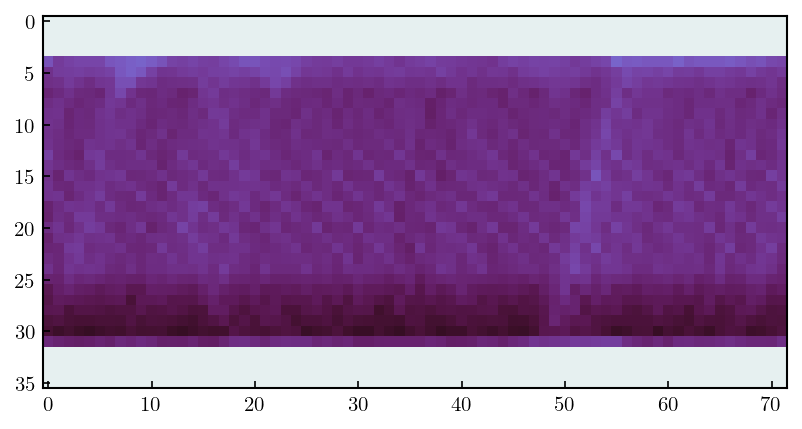

In [113]:
plt.imshow(data["tiwp_ccic_cts"].sum("time"))

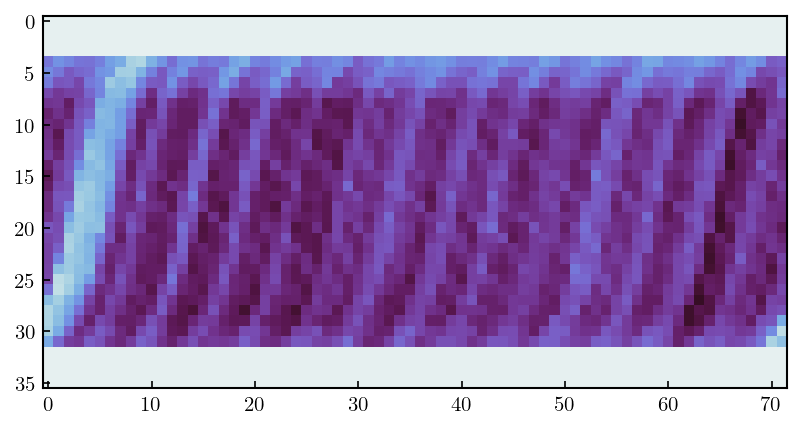

In [69]:
plt.imshow(data["tiwp_patmosx_cts"].sum("time"))

In [132]:
from pansat.products.satellite.ncei import patmosx
from pansat.environment import get_index
index = get_index(patmosx)
index.plot_availability()

OperationalError: (sqlite3.OperationalError) no such table: satellite.ncei.patmosx
[SQL: SELECT "satellite.ncei.patmosx"."key", "satellite.ncei.patmosx".start_time, "satellite.ncei.patmosx".end_time, "satellite.ncei.patmosx".local_path, "satellite.ncei.patmosx".remote_path, "satellite.ncei.patmosx".filename, "satellite.ncei.patmosx".primary_index_name, "satellite.ncei.patmosx".primary_index_start, "satellite.ncei.patmosx".primary_index_end, "satellite.ncei.patmosx".secondary_index_name, "satellite.ncei.patmosx".secondary_index_start, "satellite.ncei.patmosx".secondary_index_end, "satellite.ncei.patmosx".geometry 
FROM "satellite.ncei.patmosx"]
(Background on this error at: https://sqlalche.me/e/20/e3q8)

<Figure size 960x720 with 0 Axes>

In [130]:
index.data.table

Table('satellite.ncei.patmosx', MetaData(), Column('key', String(), table=<satellite.ncei.patmosx>, primary_key=True, nullable=False), Column('start_time', DateTime(), table=<satellite.ncei.patmosx>, nullable=False), Column('end_time', DateTime(), table=<satellite.ncei.patmosx>, nullable=False), Column('local_path', String(), table=<satellite.ncei.patmosx>, nullable=False), Column('remote_path', String(), table=<satellite.ncei.patmosx>, nullable=False), Column('filename', String(), table=<satellite.ncei.patmosx>, nullable=False), Column('primary_index_name', String(), table=<satellite.ncei.patmosx>), Column('primary_index_start', Integer(), table=<satellite.ncei.patmosx>), Column('primary_index_end', Integer(), table=<satellite.ncei.patmosx>), Column('secondary_index_name', String(), table=<satellite.ncei.patmosx>), Column('secondary_index_start', Integer(), table=<satellite.ncei.patmosx>), Column('secondary_index_end', Integer(), table=<satellite.ncei.patmosx>), Column('geometry', Lar

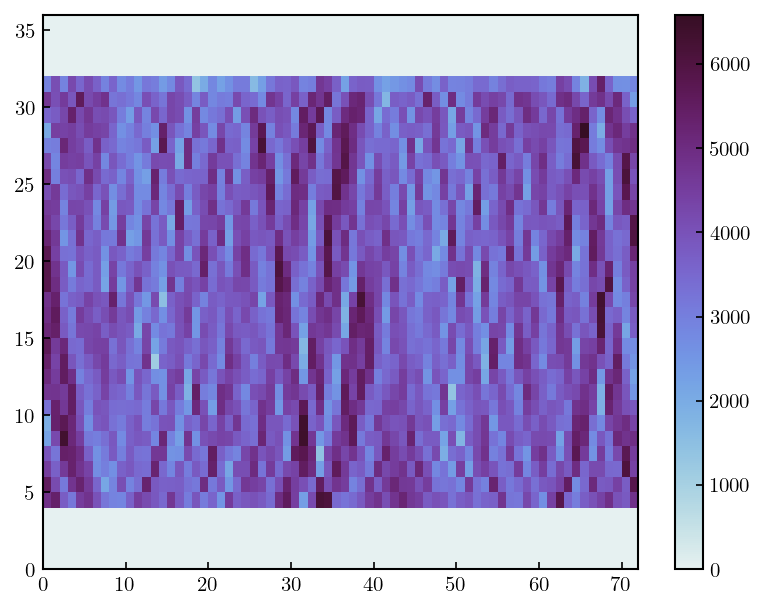

In [122]:
plt.pcolormesh(data["tiwp_ccic_cts"][0])
plt.colorbar()

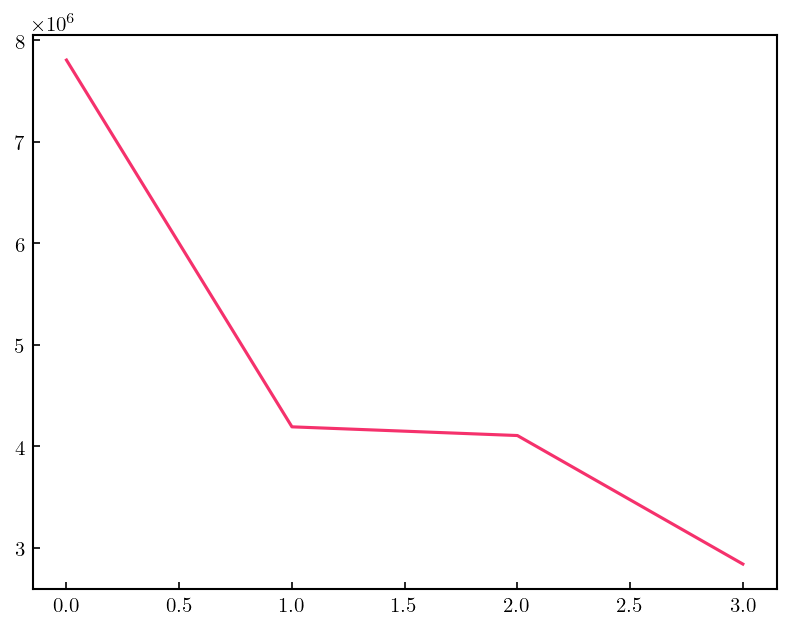

In [136]:
plt.plot(data["tiwp_ccic_cts"].sum(("latitude", "longitude")))

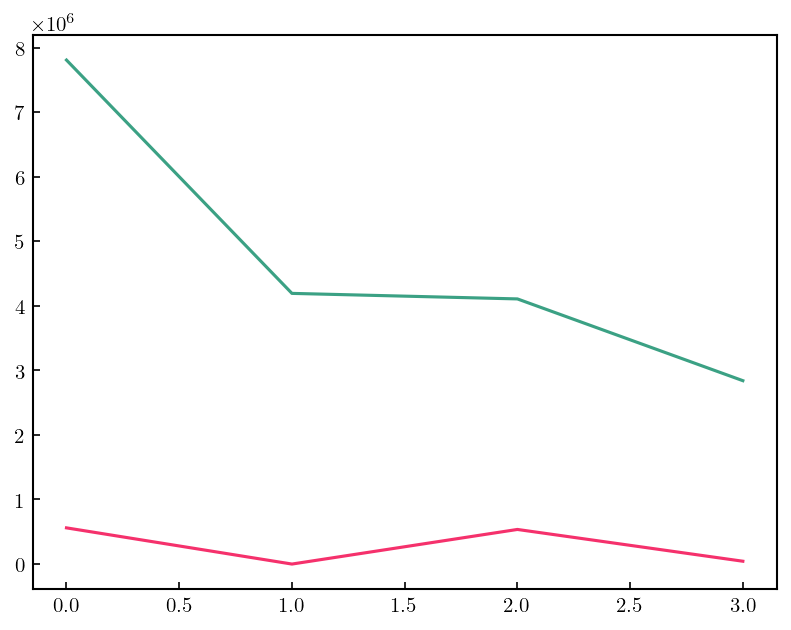

In [137]:
plt.plot(data["tiwp_patmosx_cts"].sum(("latitude", "longitude")))
plt.plot(data["tiwp_ccic_cts"].sum(("latitude", "longitude")))

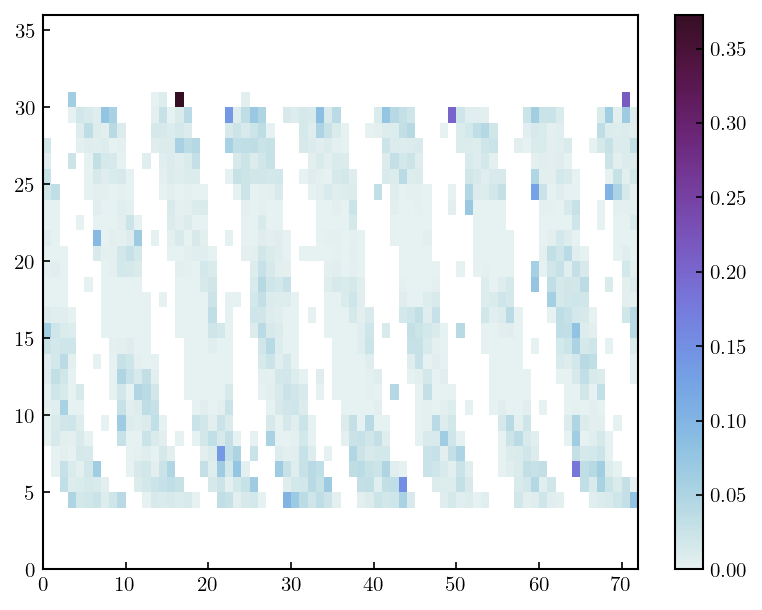

In [22]:
plt.pcolormesh(data["tiwp_isccp_sum"][0] / data["tiwp_isccp_cts"][0])
plt.colorbar()

In [33]:
files = sorted(list(Path("/scratch/ccic_record/data/collocations/monthly").glob("*.nc")))
data = []
for path in files:
    print(path)
    dataset = xr.load_dataset(path)
    parts = path.name.split("_")
    year = int(parts[-2])
    month = int(parts[-1][:-3])
    dataset["time"] = np.datetime64(f"{year}-{(month):02}-01", "ns")
    data.append(dataset)
data = xr.concat(data, "time")

/scratch/ccic_record/data/collocations/monthly/cloudsat_collocations_2009_01.nc
/scratch/ccic_record/data/collocations/monthly/cloudsat_collocations_2009_02.nc
/scratch/ccic_record/data/collocations/monthly/cloudsat_collocations_2009_03.nc
/scratch/ccic_record/data/collocations/monthly/cloudsat_collocations_2009_04.nc


/scratch/spfrnd/micromamba/envs/ccic_record/lib/python3.10/site-packages/xarray/core/dataset.py:4789: UserWarning: No index created for dimension time because variable time is not a coordinate. To create an index for time, please first call `.set_coords('time')` on this object.
  warnings.warn(


In [34]:
prods = ["ref", "modis", "ccic", "isccp", "patmosx", "dardar"]
means = xr.Dataset({
    prod: data[f"tiwp_{prod}_sum"] / data[f"tiwp_{prod}_cts"] for prod in prods
})
#means["latitude"] = (("latitude", lats.data))
weights = np.cos(np.deg2rad(means.latitude))

In [35]:
spatial_means = means.weighted(weights).mean(("longitude", "latitude"))

In [36]:
LAT_BINS = np.linspace(-90, 90, N_LATS + 1)
lats = 0.5 * (LAT_BINS[1:] + LAT_BINS[:-1])

NameError: name 'N_LATS' is not defined

[[1.         0.76545973]
 [0.76545973 1.        ]]


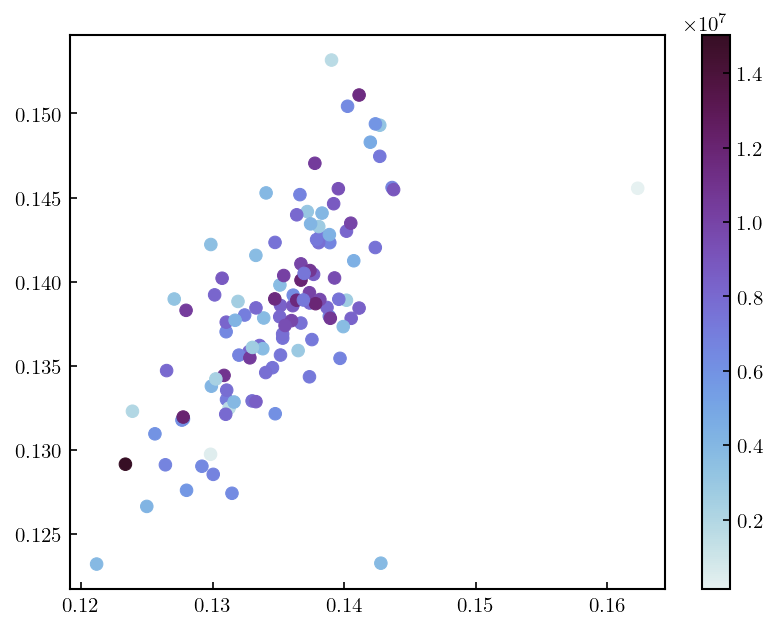

In [104]:
cts = data["tiwp_ccic_cts"].sum(("latitude", "longitude"))
mask = cts > 5e6
print(np.corrcoef(spatial_means["ccic"].data[mask], spatial_means["ref"].data[mask]))
plt.scatter(spatial_means["ccic"].data, spatial_means["ref"].data, c=cts)
plt.colorbar()

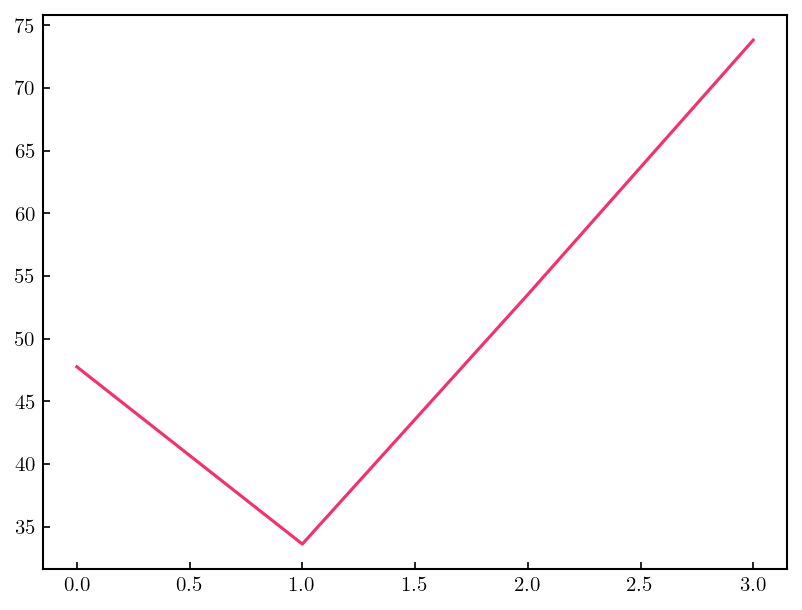

In [41]:
isccp_mean = data["tiwp_isccp_sum"] / data["tiwp_isccp_cts"]

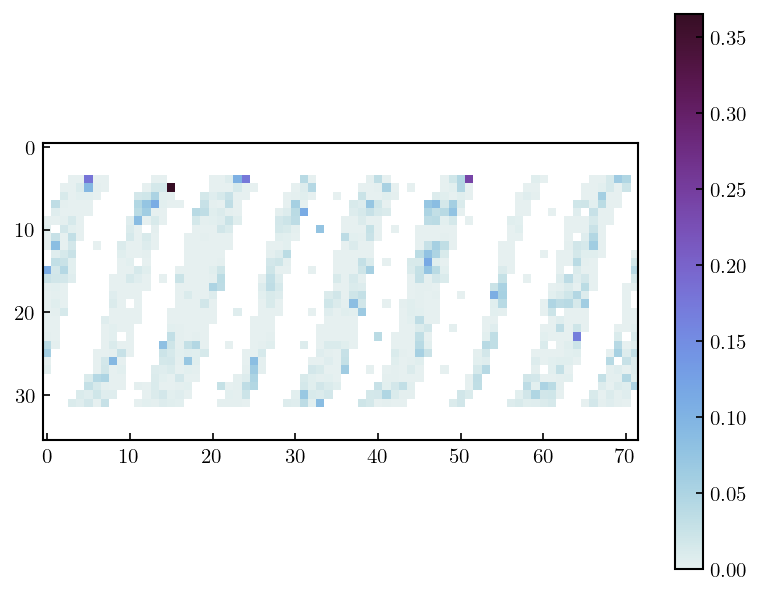

In [48]:
plt.imshow(isccp_mean[3])
plt.colorbar()

Text(0.0, 1.0, 'Monthly means')

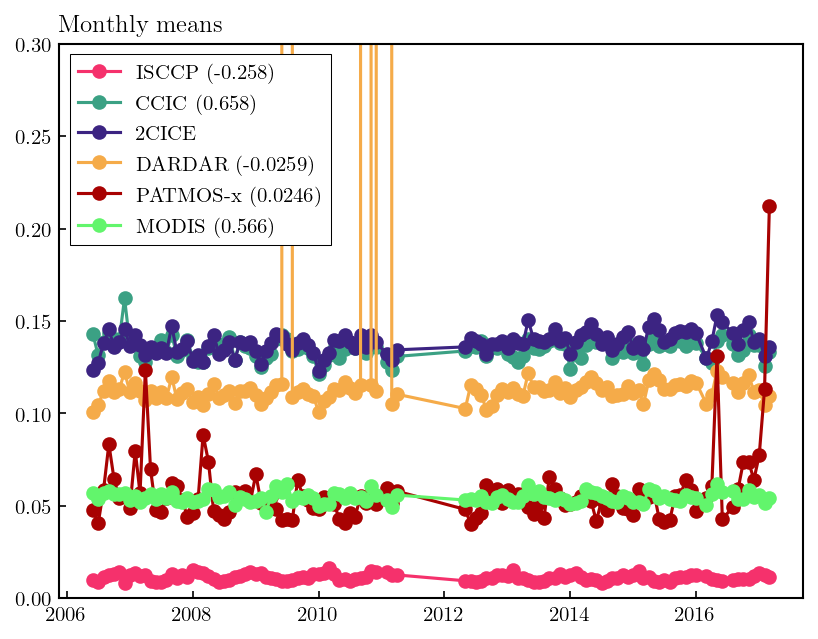

In [74]:
corr_ccic = np.corrcoef(spatial_means["ccic"].data, spatial_means["ref"].data)[0, 1]
corr_isccp = np.corrcoef(spatial_means["isccp"].data, spatial_means["ref"].data)[0, 1]
corr_dardar = np.corrcoef(spatial_means["dardar"].data, spatial_means["ref"].data)[0, 1]
corr_patmosx = np.corrcoef(spatial_means["patmosx"].data, spatial_means["ref"].data)[0, 1]
corr_modis = np.corrcoef(spatial_means["modis"].data, spatial_means["ref"].data)[0, 1]

x = spatial_means.time
plt.plot(x, spatial_means["isccp"], label=f"ISCCP ({corr_isccp:0.3})", marker="o")
plt.plot(x, spatial_means["ccic"], label=f"CCIC ({corr_ccic:0.3})", marker="o")
plt.plot(x, spatial_means["ref"], label="2CICE", marker="o")
plt.plot(x, spatial_means["dardar"], label=f"DARDAR ({corr_dardar:0.3})", marker="o")
plt.plot(x, spatial_means["patmosx"] / 1e3, label=f"PATMOS-x ({corr_patmosx:0.3})", marker="o")
plt.plot(x, spatial_means["modis"], label=f"MODIS ({corr_modis:0.3})", marker="o")
plt.ylim(0, 0.3)
plt.legend()
plt.title("Monthly means")

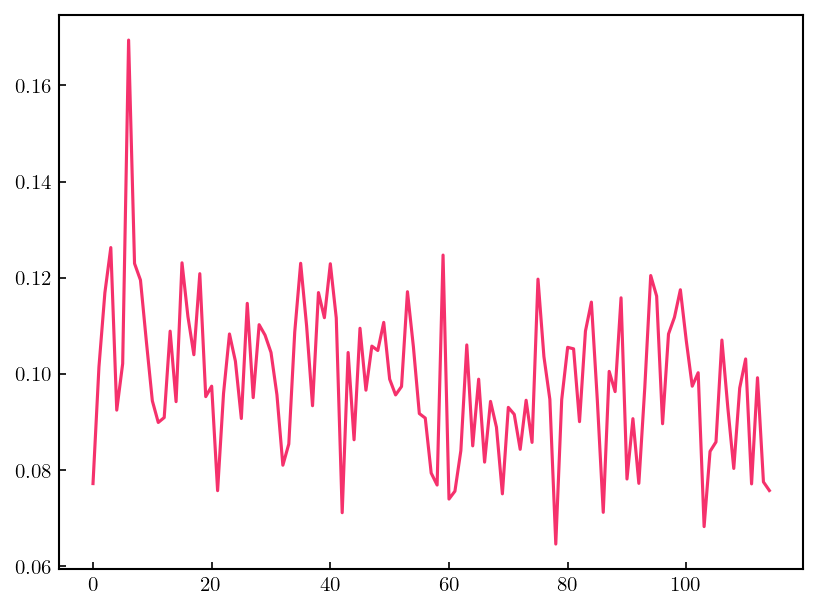

In [138]:
plt.plot(((data["tiwp_ccic_ref_sum"] - data["tiwp_ccic_sum"]) / data["tiwp_ccic_cts"]).mean(("latitude", "longitude")))

(-0.01, 0.01)

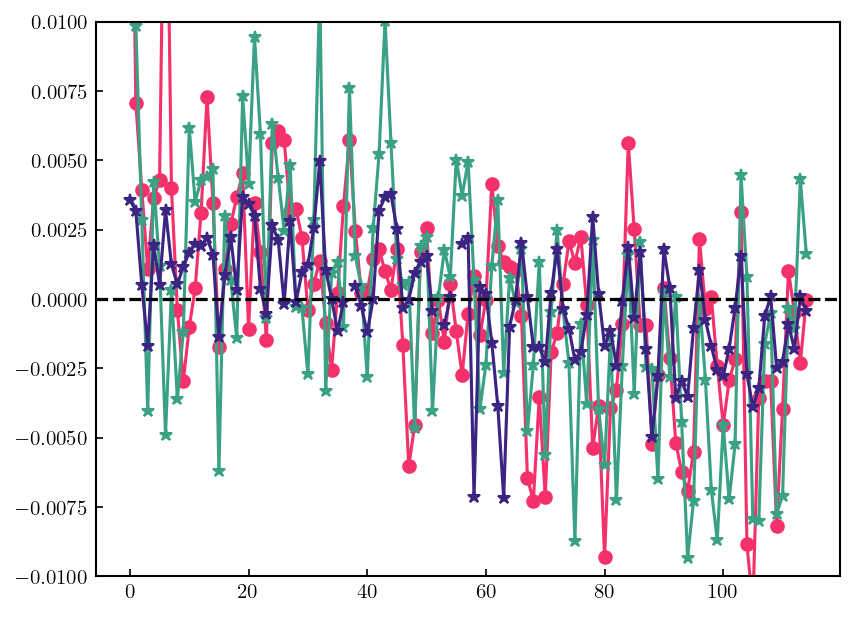

In [131]:
ann = spatial_means["ccic"] - spatial_means["ref"]
ann[np.abs(ann) > 1e3] = np.nan
plt.plot(ann - np.nanmean(ann), marker="o")
ann = spatial_means["modis"] - spatial_means["ref"]
ann[np.abs(ann) > 1e3] = np.nan
plt.plot(ann - np.nanmean(ann), marker="*")
plt.axhline(y=0, c="k", ls="--")
ann = spatial_means["dardar"] - spatial_means["ref"]
ann[np.abs(ann) > 1e3] = np.nan
plt.plot(ann - np.nanmean(ann), marker="*")
plt.axhline(y=0, c="k", ls="--")
plt.ylim(-0.01, 0.01)

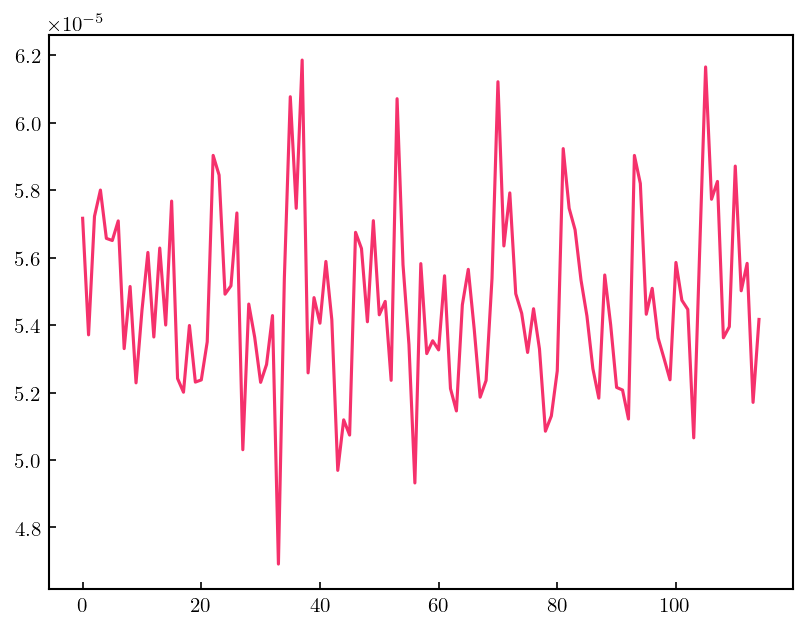

In [73]:
plt.plot(spatial_means["modis"] / 1e3, label="PATMOS-x")

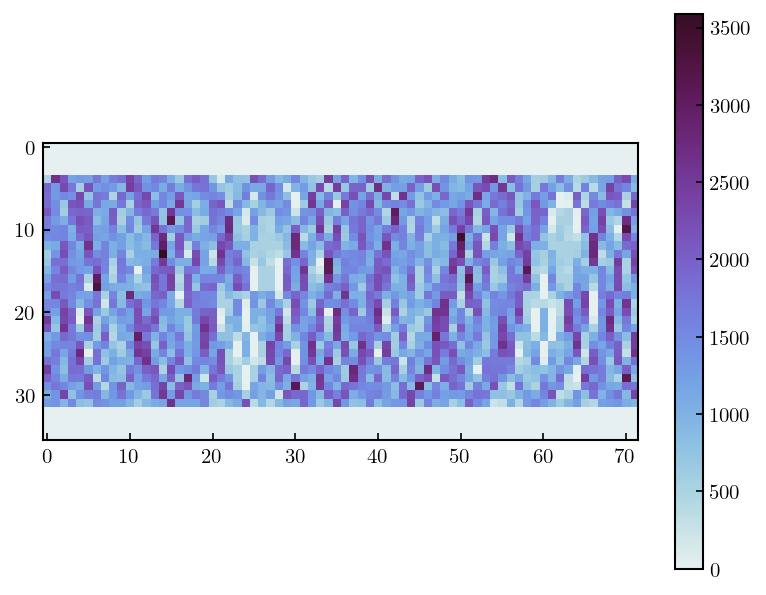

In [88]:
plt.imshow(data["tiwp_ccic_cts"][5])
plt.colorbar()

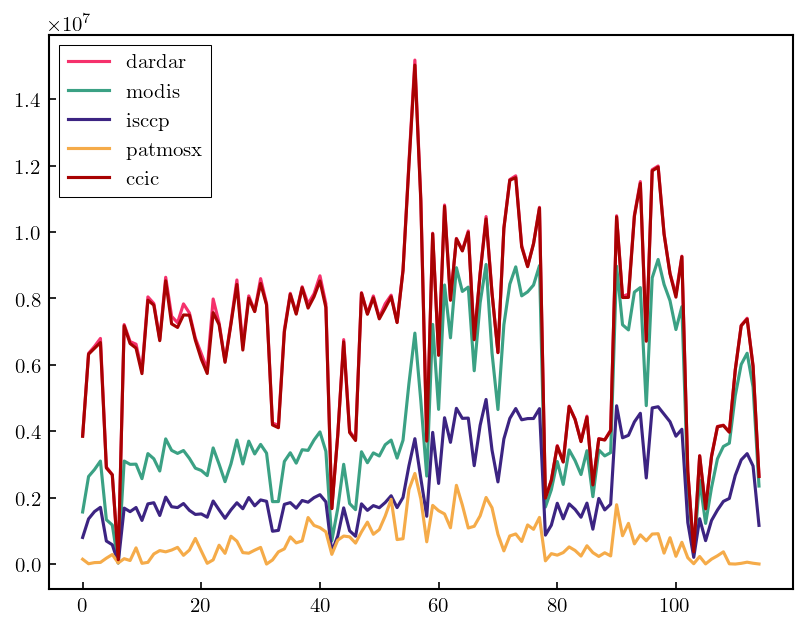

In [91]:
for prod in products:
    plt.plot(data[f"tiwp_{prod}_cts"].sum(("latitude", "longitude")), label=prod)
plt.legend()

In [3]:
from pansat.environment import get_index
from pansat.products.satellite.cloudsat import l2b_cldclass_lidar
index = get_index(l2b_cldclass_lidar)

In [7]:
data = xr.load_dataset("/scratch/ccic_record/data/collocations/patmosx/patmosx_20070101040934_03609.nc")

In [10]:
np.isfinite(data.scan_line_time).mean()

<xarray.DataArray 'scan_line_time' ()> Size: 8B
array(0.50122704)
Coordinates:
    time     datetime64[ns] 8B 2007-01-01

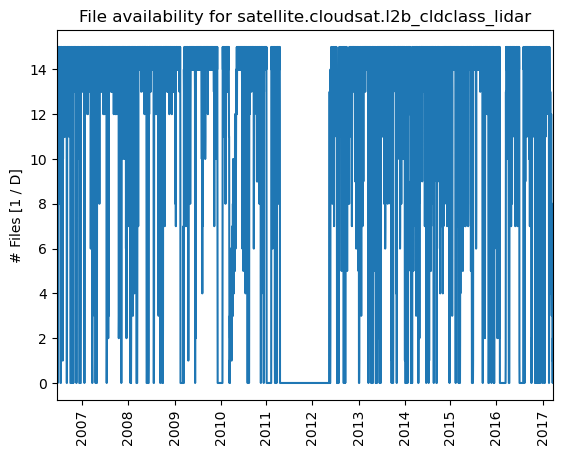

In [5]:
index.plot_availability();

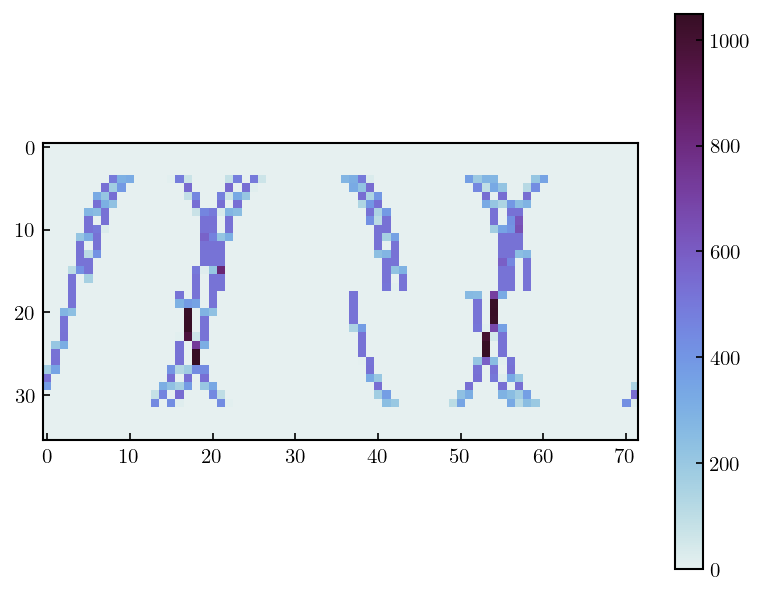

In [87]:
plt.imshow(data["tiwp_ccic_cts"][6])
plt.colorbar()

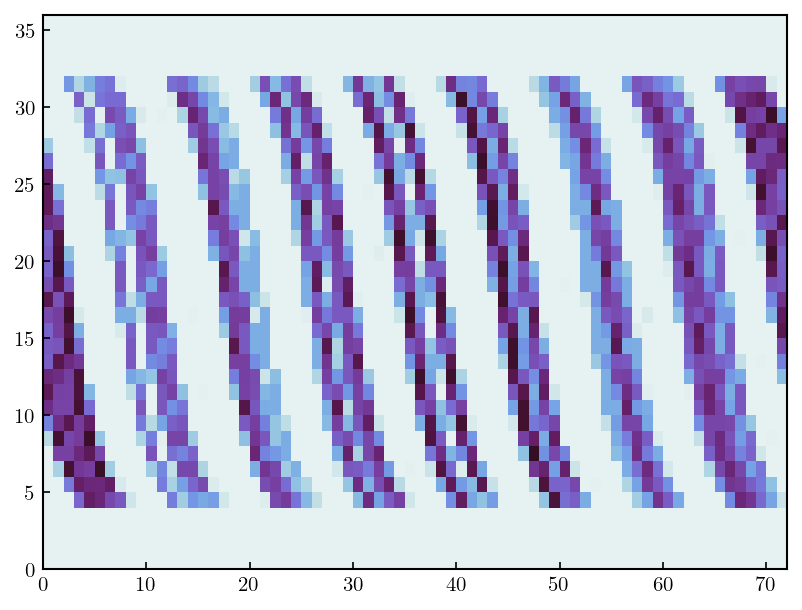

In [59]:
plt.pcolormesh(data["tiwp_isccp_cts"][2])

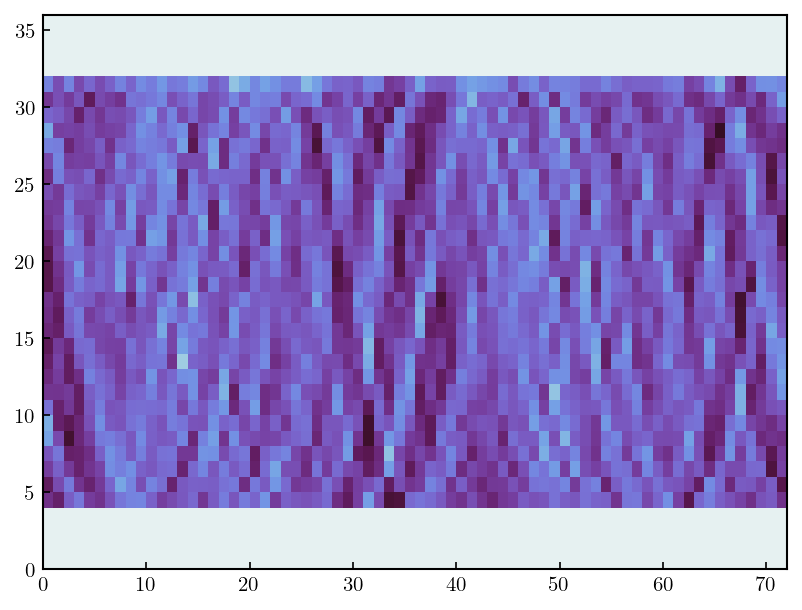

In [54]:
plt.pcolormesh(data["tiwp_ccic_cts"][0])

In [75]:
zonal_means = means.weighted(weights).mean(("longitude", "time"))

In [76]:
zonal_means.latitude

<xarray.DataArray 'latitude' (latitude: 36)> Size: 288B
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])
Dimensions without coordinates: latitude

Text(0, 0.5, 'TIWP [kg / m$^{-2}$]')

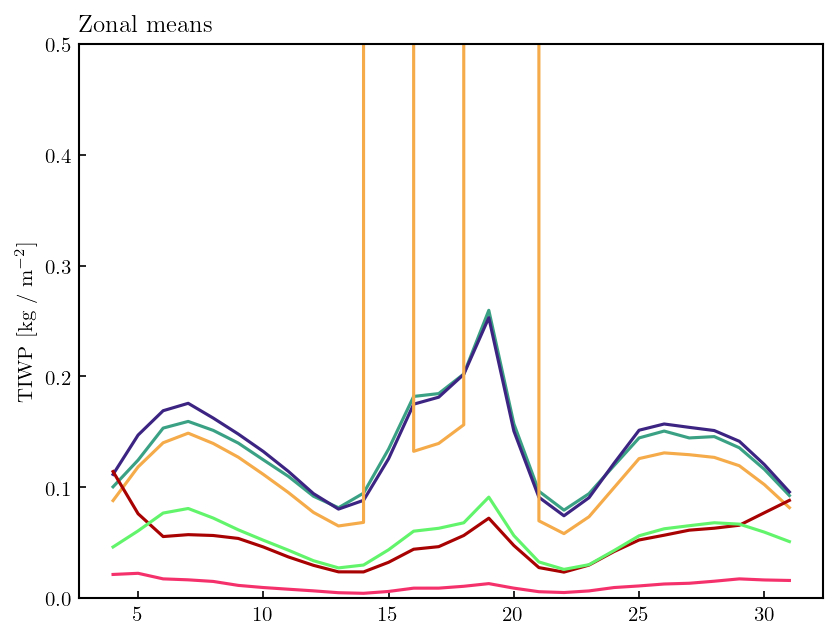

In [77]:
x = zonal_means.latitude
plt.plot(x, zonal_means.isccp)
plt.plot(x, zonal_means.ccic)
plt.plot(x, zonal_means["ref"])
plt.plot(x, zonal_means["dardar"])
plt.plot(x, zonal_means["patmosx"] / 1e3)
plt.plot(x, zonal_means["modis"])
plt.title("Zonal means")
plt.ylim(0, 0.5)
plt.ylabel("TIWP [kg / m$^{-2}$]")

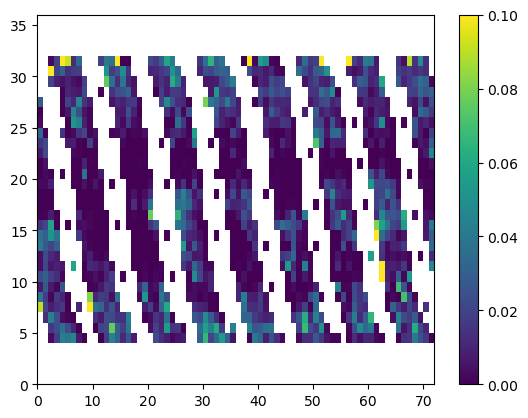

In [167]:
plt.pcolormesh(data.tiwp_isccp_sum / data.tiwp_isccp_cts, vmin=0, vmax=0.1)
plt.colorbar()

ValueError: For X (37) and Y (116) with flat shading, A should have shape (115, 36, 3) or (115, 36, 4) or (115, 36) or (4140,), not (115, 36, 72)

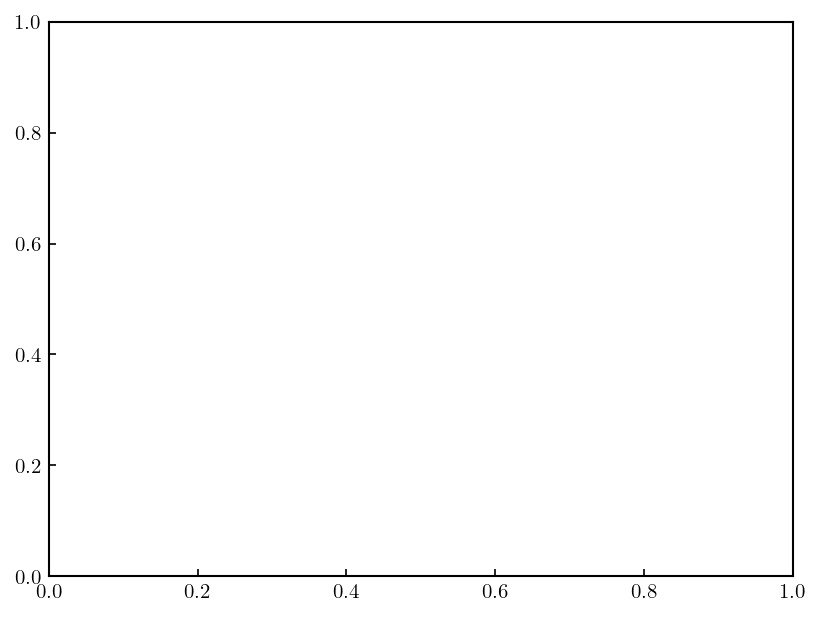

In [78]:
plt.pcolormesh(data.tiwp_modis_sum / data.tiwp_modis_cts, vmin=0, vmax=1)
plt.colorbar()

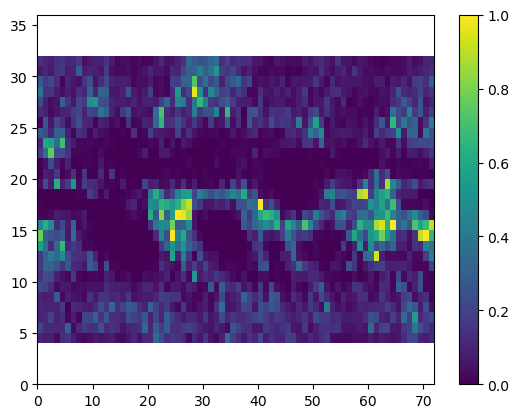

In [171]:
plt.pcolormesh(data.tiwp_ccic_sum / data.tiwp_ccic_cts, vmin=0, vmax=1)
plt.colorbar()

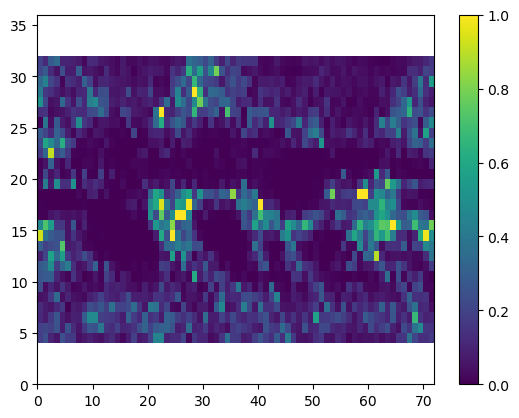

In [173]:
plt.pcolormesh(data.tiwp_ref_sum / data.tiwp_ref_cts, vmin=0, vmax=1)
plt.colorbar()

In [15]:
cs_data = xr.load_dataset(cloudsat_granules[granule])
cs_data = cs_data.rename(
    iwp_ccic="tiwp_ccic",
    iwp_2cice="tiwp_2cice",
    iwp_dardar="tiwp_dardar"
)
cs_data["tiwp_modis"] = get_tiwp_modis(xr.load_dataset(modis_granules[granule])).interp(time=cs_data.time)
cs_data["tiwp_isccp"] = get_tiwp_isccp(xr.load_dataset(isccp_granules[granule]))
cs_data["tiwp_patmosx"] = get_tiwp_patmosx(xr.load_dataset(patmosx_granules[granule]))

(0.01, 10.0)

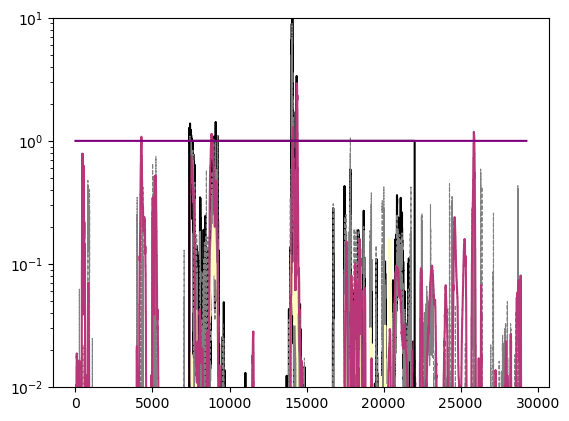

In [27]:
from matplotlib.cm import magma

colors = [magma(x) for x in np.linspace(0, 1, 7)]

f, ax = plt.subplots(1, 1)

ax.plot(cs_data.tiwp_2cice, c="k")
ax.plot(cs_data.tiwp_dardar, c="grey", ls="--", lw=0.8)

ax.plot(cs_data.tiwp_isccp, c=colors[-1])
#ax.plot(cs_data.tiwp_modis, c=colors[1])
#ax.plot(cs_data.tiwp_patmosx, c=colors[2])
ax.plot(cs_data.tiwp_ccic, c=colors[3])
plt.plot(np.isfinite(cs_data.cloud_mask_2cice.data), c="k")
plt.plot(np.isfinite(cs_data.cloud_mask_dardar.data), c="purple")
ax.set_yscale("log")
ax.set_ylim(1e-2, 1e1)

##

In [176]:
cs_data_t = cs_data.reindex({"rays": cs_data.time})
cs_data_t.interp(rays=tiwp_modis.time)

<xarray.Dataset>
Dimensions:            (rays: 28146)
Coordinates:
    longitude          (rays) float64 nan nan nan nan nan ... nan nan nan nan
    latitude           (rays) float64 nan nan nan nan nan ... nan nan nan nan
  * rays               (rays) datetime64[ns] 2014-01-14T18:00:25 ... 2014-01-...
    time               (rays) datetime64[ns] 2014-01-14T18:00:25 ... 2014-01-...
Data variables:
    iwp_ccic           (rays) float64 nan nan nan nan nan ... nan nan nan nan
    iwp_2cice          (rays) float64 nan nan nan nan nan ... nan nan nan nan
    iwp_dardar         (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_ccic    (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_2cice   (rays) float64 nan nan nan nan nan ... nan nan nan nan
    cloud_mask_dardar  (rays) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    cloudsat_granule:    41048
    cloudsat_timestamp:  2014014180017

In [102]:
cloudsat_granules[granule]

PosixPath('/home/simonpf/sun/cloudsat_hanna/output2/ccicgridsat_dardar_2cice_2014014180017_41048.nc')

In [98]:
cs_data.latitude.max()

<xarray.DataArray 'latitude' ()>
array(68.99603, dtype=float32)

In [154]:
tiwp_modis.time.data.min()
cs_data.time.data.max()

numpy.datetime64('2014-01-14T19:39:10.179687500')

In [149]:
np.diff(cs_data.time).max()

numpy.timedelta64(642078125000,'ns')

In [51]:
k

<xarray.Dataset>
Dimensions:                        (rays: 37082, modis_pixels: 15,
                                    modis_granule: 22)
Coordinates:
  * rays                           (rays) int64 0 1 2 3 ... 37079 37080 37081
  * modis_pixels                   (modis_pixels) int64 0 1 2 3 ... 11 12 13 14
  * modis_granule                  (modis_granule) int64 0 1 2 3 ... 18 19 20 21
    latitude                       (rays, modis_pixels) float32 0.02063 ... -...
    longitude                      (rays, modis_pixels) float32 116.5 ... 91.84
    time                           (rays) datetime64[ns] 2014-01-14T18:00:25 ...
Data variables:
    cloud_phase                    (rays, modis_pixels) int8 0 0 0 0 ... 0 0 0 0
    cloud_phase_scale_factor       (modis_granule) float64 1.0 1.0 ... -999.0
    cloud_phase_offset             (modis_granule) float64 0.0 0.0 ... -999.0
    cloud_water_path               (rays, modis_pixels) int16 -9999 ... -9999
    cloud_water_path_offset        (modis_granule) float64 0.0 0.0 ... -999.0
    cloud_water_path_scale_factor  (modis_granule) float64 1.0 1.0 ... -999.0
    modis_granule_index            (rays, modis_pixels) int8 1 1 1 ... 21 21 21

In [41]:
cs_data = xr.load_dataset(cloudsat_granules[granule])

In [84]:
modis_data = xr.load_dataset(modis_granules[granule])[{"modis_pixels": 7}]
modis_data = modis_data.reindex({"rays": modis_data.time})


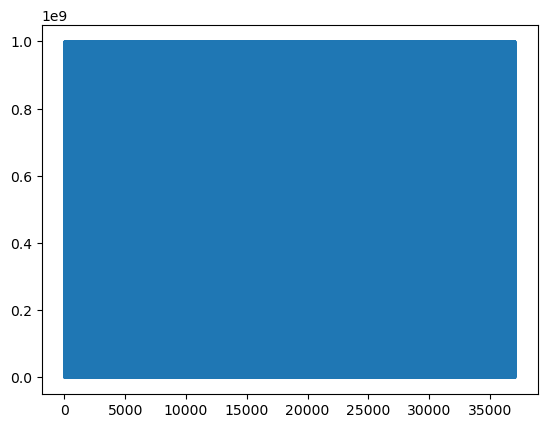

In [88]:
plt.plot(np.diff(modis_data.rays))

In [78]:
np.diff(cs_data.time).max()

numpy.timedelta64(642078125000,'ns')

In [86]:
modis_data = modis_data.interp(rays=cs_data.time)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

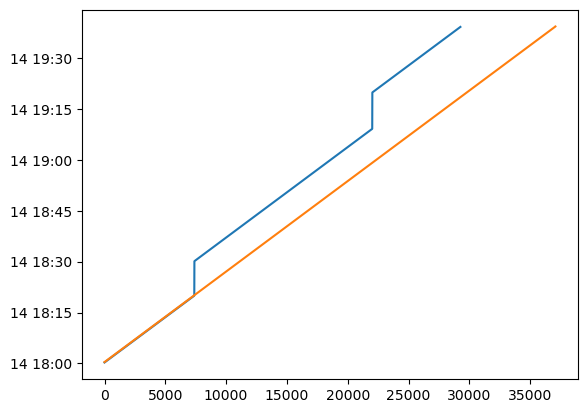

In [70]:
plt.plot(cs_data.time)
plt.plot(modis_data.rays)

In [214]:
granule = next(iter(common))

data = xr.load_dataset(cloudsat_granules[granule])[["iwp_ccic", "iwp_2cice", "iwp_dardar"]]
data["tiwp_modis"] = get_tiwp_modis(xr.load_dataset(modis_granules[granule])).interp(time=data.time)
data["tiwp_isccp"] = get_tiwp_isccp(xr.load_dataset(isccp_granules[granule]))

[29267 29267 29267 29267 29267 29267 29267 29267 29267 29267 29267 29267
 29267 29267 29267 29267 29267 29267]
[15978 15978 15978 15978 15978 15978 15978 15978 15978 15978 15978 15978
 15978 15978 15978 15979 15978 15978]


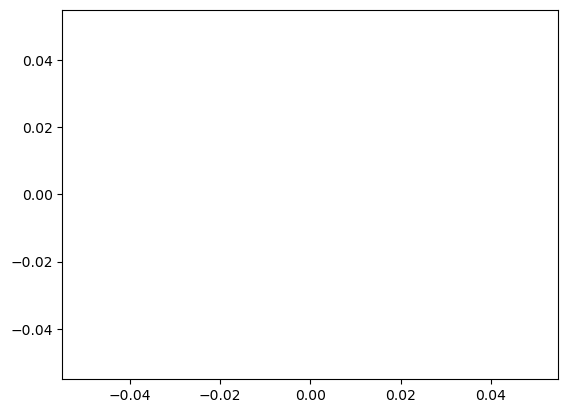

In [217]:
#plt.plot(data.tiwp_modis)
plt.plot(data.tiwp_isccp)

In [5]:
modis_files = sorted(list(Path("/data/ccic/collocations/modis/").glob("modis_2015*")))

In [8]:
tiwp_modis = get_tiwp_modis(xr.load_dataset(modis_files[0]))

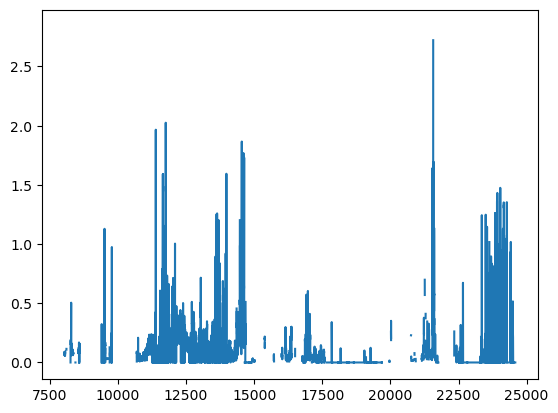

In [10]:
plt.plot(tiwp_modis)

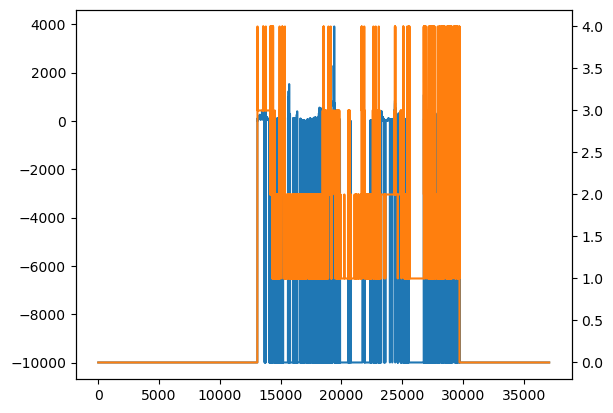

In [34]:
plt.plot(modis_data.cloud_water_path[{"modis_pixels": 8}])
plt.twinx()
plt.plot(modis_data.cloud_phase[{"modis_pixels": 8}], c="C1")

In [38]:
tiwp.mean()

<xarray.DataArray ()> Size: 4B
array(64.16612, dtype=float32)

In [46]:
valid = np.isfinite(tiwp.data)
tiwp_valid = tiwp.data[valid]
(tiwp_valid > 0).mean()

0.6458821690889202

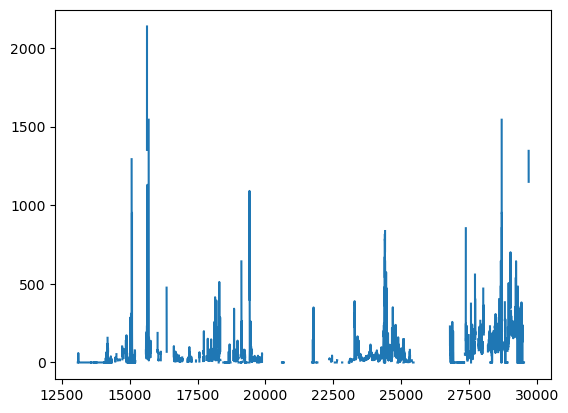

In [35]:
tiwp = get_tiwp_modis(modis_data)
plt.plot(tiwp)

In [56]:
GRANULE_PATH = Path("/data/ccic/collocations")
modis_collocations = find_granules(GRANULE_PATH / "modis")
isccp_collocations = find_granules(GRANULE_PATH / "isccp")
patmosx_collocations = find_granules(GRANULE_PATH / "patmosx")

In [59]:
patmosx_data = xr.load_dataset(next(iter(patmosx_collocations.values())))

In [60]:
patmosx_data

<xarray.Dataset> Size: 3MB
Dimensions:                     (rays: 37081)
Coordinates:
    time                        datetime64[ns] 8B 2014-12-31
    latitude                    (rays) float64 297kB -0.002947 ... 0.008887
    longitude                   (rays) float64 297kB 28.49 28.48 ... 3.769 3.766
  * rays                        (rays) int64 297kB 0 1 2 3 ... 37078 37079 37080
    surface_elevation           (rays) int64 297kB 938 953 952 ... -9999 -9999
Data variables:
    scan_line_time              (rays) datetime64[ns] 297kB 2015-01-01T00:41:...
    cloud_fraction              (rays) float64 297kB 1.0 1.0 1.0 ... 1.0 1.0 1.0
    cloud_fraction_uncertainty  (rays) float64 297kB 0.06385 ... 0.0003836
    cloud_mask                  (rays) float64 297kB 2.491 2.458 ... 3.0 3.0
    cld_cwp_dcomp               (rays) float64 297kB nan nan nan ... nan nan nan
    dcomp_quality               (rays) float64 297kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ice_cloud_probability       (rays) float64 297kB 0.4198 0.4169 ... 0.7832
Attributes: (12/99)
    summary:                               Included in this file are PATMOS-x...
    institution:                           NOAA/NESDIS and the University of ...
    cdr_program:                           NOAA Climate Data Record Program
    title:                                PATMOS-x AVHRR reflectance, brightn...
    keywords:                             Earth Science > Atmosphere > Atmosp...
    keywords_vocabulary:                  NASA Global Change Master Directory...
    ...                                   ...
    MEAN_TEMPERATURE_3_750UM_NOM:         267.9732663350061
    _History:                             
    product_version:                      v06r00
    HIRSAVHRR_tpw_rtvl_product_version:   v01r01
    HIRSAVHRR_tpw_rtvl_date_issued:       2019-03-01
    HIRSAVHRR_TPW_coef_fn:                HIRS_AVHRR_TPW_regcoef_metop_2_shif...

In [ ]:
modis_granules = find_granules("/data/ccic/collocations/modis/")
dardar_granules = find_granules("/home/simonpf/sun/cloudsat_hanna/output")
common = set(modis_granules.keys()).intersection(set(dardar_granules.keys()))

In [ ]:
modis_data = xr.load_dataset(modis_granules[next(iter(common))])
dardar_data = xr.load_dataset(dardar_granules[next(iter(common))])

In [5]:
modis_iwp = modis_data.cloud_water_path.data.copy()

NameError: name 'modis_data' is not defined

In [50]:
from scipy.ndimage import gaussian_filter_1d
iwp_dardar = dardar_data.iwp_dardar.data


ModuleNotFoundError: No module named 'scipy'

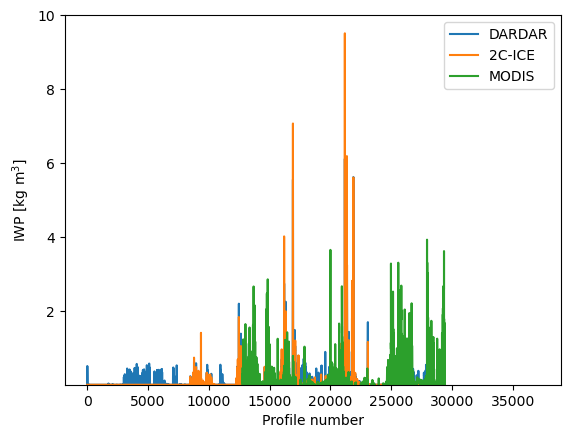

In [54]:
plt.plot(dardar_data.iwp_dardar, label="DARDAR")
plt.plot(dardar_data.iwp_2cice, label="2C-ICE")
#plt.plot(dardar_data.iwp_ccic, label="CCIC")
plt.plot(modis_data.cloud_water_path[{"modis_pixels": 8}] / 1e3, label="MODIS")
plt.ylim([1e-3, 1e1])
plt.xlabel("Profile number")
plt.ylabel("IWP [kg m$^3]$")

plt.legend()

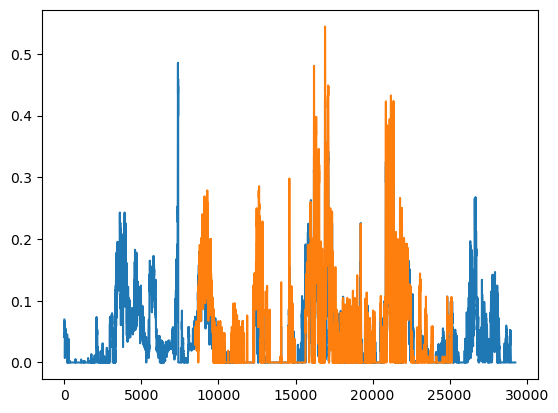

In [47]:
plt.plot(dardar_data.cloud_mask_dardar)
plt.plot(dardar_data.cloud_mask_2cice)
